To do before submitting 
- check status of the table of contents (all corretly linked?)
- once import statemtn is final move it to the cells where i open the pickle files
- the columns that I end up removing before imputing maybe put them in the cleaning function, then may need to repickle
- say somewhere that I am going off my Term 1 project for some of this
- the clean data function refers to unknowns instead of df2 
- try timing the ML models to help decide which one to do
- split part 2 into sections base and optimize

# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

## Table of Contents

1. [Introduction](#intro)
2. [Part 0: Get to Know the Data](#part0)  
  2.1 [Encode Missing or Unknown Values](#part0unknowns)<br>
  2.2 [Assess Missing Data in Columns and Rows](#part0missing)<br>
  2.3 [Select and Re-Encode Features](#part0reencode)<br>
  2.4 [Create a Cleaning Function](#part0clean)<br>
  2.5 [Impute Missing Values](#part0impute)<br>
  2.6 [Apply Feature Scaling](#part0scaling)<br>
3. [Part 1: Customer Segmentation Report](#part1)<br>
  3.1 [Dimentionality Reduction](#part1pca)<br>
  3.2 [Interpret Principal Components]((#part1interpretPCA)<br>
  3.3 [Perform K-Means Clustering](#part1clustering)<br>
  3.4 [Compare Customer Data to Demographics Data](#part1compare)<br>
4. [Part 2: Supervised Learning Model](#part2)<br>
  4.1 [Base Machine Learning Models](#part1base)<br>
  4.2 [Optimize A Single Model](#part1optimize)<br>
5. [Part 3: Kaggle Competition](#part3)
6. [Conclusions](#conclusions)  
7. [Resources](#resources)

<a id='intro'></a> 
## Introduction

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [2]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import time
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from collections import Counter
from operator import itemgetter
from sklearn.metrics import fbeta_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# magic word for producing visualizations in notebook
%matplotlib inline

<a id='part0'></a>
## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

<a id='part0unknowns'></a>
### Encode missing or unknown values 

In [2]:
# load in the azdias dataset 
azdias = pd.read_csv('azdias.csv')
del azdias['Unnamed: 0']

C:\Users\ursula\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# Print number of rows and columns in the azdias dataframe
azdias.shape

(891221, 366)

In [4]:
# Print first 5 rows of the azdias dataframe
azdias.head()

LNR  AGER_TYP  AKT_DAT_KL  ALTER_HH  ALTER_KIND1  ALTER_KIND2  \
0  910215        -1         NaN       NaN          NaN          NaN   
1  910220        -1         9.0       0.0          NaN          NaN   
2  910225        -1         9.0      17.0          NaN          NaN   
3  910226         2         1.0      13.0          NaN          NaN   
4  910241        -1         1.0      20.0          NaN          NaN   

   ALTER_KIND3  ALTER_KIND4  ALTERSKATEGORIE_FEIN  ANZ_HAUSHALTE_AKTIV  \
0          NaN          NaN                   NaN                  NaN   
1          NaN          NaN                  21.0                 11.0   
2          NaN          NaN                  17.0                 10.0   
3          NaN          NaN                  13.0                  1.0   
4          NaN          NaN                  14.0                  3.0   

          ...           VHN  VK_DHT4A  VK_DISTANZ  VK_ZG11  W_KEIT_KIND_HH  \
0         ...           NaN       NaN         NaN      NaN             NaN   
1         ...           4.0       8.0        11.0     10.0             3.0   
2         ...           2.0       9.0         9.0      6.0             3.0   
3         ...           0.0       7.0        10.0     11.0             NaN   
4         ...           2.0       3.0         5.0      4.0             2.0   

   WOHNDAUER_2008  WOHNLAGE ZABEOTYP ANREDE_KZ ALTERSKATEGORIE_GROB  
0             NaN       NaN        3         1                    2  
1             9.0       4.0        5         2                    1  
2             9.0       2.0        5         2                    3  
3             9.0       7.0        3         2                    4  
4             9.0       3.0        4         1                    3  

[5 rows x 366 columns]

In [5]:
# Determine number of non-null values for each column of the azdias dataframe
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(267), int64(93), object(6)
memory usage: 2.4+ GB


In [6]:
for col in azdias.columns:
    if azdias[col].dtype == np.int64:
        azdias[col] = azdias[col].astype(np.float64)

LNR
AGER_TYP
D19_BANKEN_ANZ_12
D19_BANKEN_ANZ_24
D19_BANKEN_DATUM
D19_BANKEN_DIREKT
D19_BANKEN_GROSS
D19_BANKEN_LOKAL
D19_BANKEN_OFFLINE_DATUM
D19_BANKEN_ONLINE_DATUM
D19_BANKEN_REST
D19_BEKLEIDUNG_GEH
D19_BEKLEIDUNG_REST
D19_BILDUNG
D19_BIO_OEKO
D19_BUCH_CD
D19_DIGIT_SERV
D19_DROGERIEARTIKEL
D19_ENERGIE
D19_FREIZEIT
D19_GARTEN
D19_GESAMT_ANZ_12
D19_GESAMT_ANZ_24
D19_GESAMT_DATUM
D19_GESAMT_OFFLINE_DATUM
D19_GESAMT_ONLINE_DATUM
D19_HANDWERK
D19_HAUS_DEKO
D19_KINDERARTIKEL
D19_KONSUMTYP_MAX
D19_KOSMETIK
D19_LEBENSMITTEL
D19_NAHRUNGSERGAENZUNG
D19_RATGEBER
D19_REISEN
D19_SAMMELARTIKEL
D19_SCHUHE
D19_SONSTIGE
D19_TECHNIK
D19_TELKO_ANZ_12
D19_TELKO_ANZ_24
D19_TELKO_DATUM
D19_TELKO_MOBILE
D19_TELKO_OFFLINE_DATUM
D19_TELKO_ONLINE_DATUM
D19_TELKO_REST
D19_TIERARTIKEL
D19_VERSAND_ANZ_12
D19_VERSAND_ANZ_24
D19_VERSAND_DATUM
D19_VERSAND_OFFLINE_DATUM
D19_VERSAND_ONLINE_DATUM
D19_VERSAND_REST
D19_VERSI_ANZ_12
D19_VERSI_ANZ_24
D19_VERSI_DATUM
D19_VERSI_OFFLINE_DATUM
D19_VERSI_ONLINE_DATUM
D19_VERS

In [7]:
# Generate descriptive statistics that summarize the azdias dataframe
azdias.describe()

LNR       AGER_TYP     AKT_DAT_KL       ALTER_HH  \
count  8.912210e+05  891221.000000  817722.000000  817722.000000   
mean   6.372630e+05      -0.358435       4.421928      10.864126   
std    2.572735e+05       1.198724       3.638805       7.639683   
min    1.916530e+05      -1.000000       1.000000       0.000000   
25%    4.144580e+05      -1.000000       1.000000       0.000000   
50%    6.372630e+05      -1.000000       3.000000      13.000000   
75%    8.600680e+05      -1.000000       9.000000      17.000000   
max    1.082873e+06       3.000000       9.000000      21.000000   

        ALTER_KIND1   ALTER_KIND2  ALTER_KIND3  ALTER_KIND4  \
count  81058.000000  29499.000000  6170.000000  1205.000000   
mean      11.745392     13.402658    14.476013    15.089627   
std        4.097660      3.243300     2.712427     2.452932   
min        2.000000      2.000000     4.000000     7.000000   
25%        8.000000     11.000000    13.000000    14.000000   
50%       12.000000     14.000000    15.000000    15.000000   
75%       15.000000     16.000000    17.000000    17.000000   
max       18.000000     18.000000    18.000000    18.000000   

       ALTERSKATEGORIE_FEIN  ANZ_HAUSHALTE_AKTIV          ...           \
count         628274.000000        798073.000000          ...            
mean              13.700717             8.287263          ...            
std                5.079849            15.628087          ...            
min                0.000000             0.000000          ...            
25%               11.000000             1.000000          ...            
50%               14.000000             4.000000          ...            
75%               17.000000             9.000000          ...            
max               25.000000           595.000000          ...            

                 VHN       VK_DHT4A     VK_DISTANZ        VK_ZG11  \
count  770025.000000  815304.000000  815304.000000  815304.000000   
mean        2.417322       6.001214       7.532130       5.945972   
std         1.166572       2.856091       3.247789       2.771464   
min         0.000000       1.000000       1.000000       1.000000   
25%         2.000000       3.000000       5.000000       4.000000   
50%         2.000000       6.000000       8.000000       6.000000   
75%         3.000000       9.000000      10.000000       8.000000   
max         4.000000      11.000000      13.000000      11.000000   

       W_KEIT_KIND_HH  WOHNDAUER_2008       WOHNLAGE       ZABEOTYP  \
count   783619.000000   817722.000000  798073.000000  891221.000000   
mean         3.933406        7.908791       4.052836       3.362438   
std          1.964701        1.923137       1.949539       1.352704   
min          0.000000        1.000000       0.000000       1.000000   
25%          2.000000        8.000000       3.000000       3.000000   
50%          4.000000        9.000000       3.000000       3.000000   
75%          6.000000        9.000000       5.000000       4.000000   
max          6.000000        9.000000       8.000000       6.000000   

           ANREDE_KZ  ALTERSKATEGORIE_GROB  
count  891221.000000         891221.000000  
mean        1.522098              2.777398  
std         0.499512              1.068775  
min         1.000000              1.000000  
25%         1.000000              2.000000  
50%         2.000000              3.000000  
75%         2.000000              4.000000  
max         2.000000              9.000000  

[8 rows x 360 columns]

In [8]:
# Load the feature information and view the first 15 lines
feat_info = pd.read_excel('DIAS Attributes - Values 2017.xlsx')
del feat_info['Unnamed: 0']
feat_info.head(15)

Attribute                                   Description  Value  \
0               AGER_TYP                            best-ager typology     -1   
1                    NaN                                           NaN      0   
2                    NaN                                           NaN      1   
3                    NaN                                           NaN      2   
4                    NaN                                           NaN      3   
5   ALTERSKATEGORIE_GROB  age classification through prename analysis   -1, 0   
6                    NaN                                           NaN      1   
7                    NaN                                           NaN      2   
8                    NaN                                           NaN      3   
9                    NaN                                           NaN      4   
10                   NaN                                           NaN      9   
11              ALTER_HH                 main age within the household      0   
12                   NaN                                           NaN      1   
13                   NaN                                           NaN      2   
14                   NaN                                           NaN      3   

                             Meaning  
0                            unknown  
1         no classification possible  
2                    passive elderly  
3                   cultural elderly  
4          experience-driven elderly  
5                            unknown  
6                         < 30 years  
7                      30 - 45 years  
8                      46 - 60 years  
9                         > 60 years  
10             uniformly distributed  
11  unknown / no main age detectable  
12         01.01.1895 bis 31.12.1899  
13         01.01.1900 bis 31.12.1904  
14         01.01.1905 bis 31.12.1909

In [9]:
# It looks like the first 5 columns are for AGER_TYP (and so on) but only the first row of the
# attribute column is filled in and the rest are NaNs.  Therefore, forward this column, redefine
# this as the attribute column, and view the first 10 lines of the altered dataframe. 
feat_info_attribute = feat_info['Attribute'].fillna(method='ffill')
feat_info['Attribute'] = feat_info_attribute
feat_info.head(10)

Attribute                                   Description  Value  \
0              AGER_TYP                            best-ager typology     -1   
1              AGER_TYP                                           NaN      0   
2              AGER_TYP                                           NaN      1   
3              AGER_TYP                                           NaN      2   
4              AGER_TYP                                           NaN      3   
5  ALTERSKATEGORIE_GROB  age classification through prename analysis   -1, 0   
6  ALTERSKATEGORIE_GROB                                           NaN      1   
7  ALTERSKATEGORIE_GROB                                           NaN      2   
8  ALTERSKATEGORIE_GROB                                           NaN      3   
9  ALTERSKATEGORIE_GROB                                           NaN      4   

                      Meaning  
0                     unknown  
1  no classification possible  
2             passive elderly  
3            cultural elderly  
4   experience-driven elderly  
5                     unknown  
6                  < 30 years  
7               30 - 45 years  
8               46 - 60 years  
9                  > 60 years

In [10]:
# I want to find all the encoded values that are actually missing or unknown values that should 
# be converted to NaNs.  Therefore, subset the meaning column to contain only those values 
# containing "unknown" or "no " (such as "no classification possible"), then view the altered
# dataframe.  After scanning I do not see any abberent descriptions.  
feat_info = feat_info[(feat_info['Meaning'].str.contains("unknown") | feat_info['Meaning'].str.contains("no "))]
pd.set_option('display.max_rows', 500)
feat_info

Attribute  \
0                        AGER_TYP   
1                        AGER_TYP   
5            ALTERSKATEGORIE_GROB   
11                       ALTER_HH   
33                      ANREDE_KZ   
40                       BALLRAUM   
48                       BIP_FLAG   
49                       BIP_FLAG   
51                CAMEO_DEUG_2015   
105            CAMEO_DEUINTL_2015   
131                 CJT_GESAMTTYP   
138             D19_BANKEN_ANZ_12   
145             D19_BANKEN_ANZ_24   
161              D19_BANKEN_DATUM   
162          D19_BANKEN_DIREKT_RZ   
170           D19_BANKEN_GROSS_RZ   
178           D19_BANKEN_LOKAL_RZ   
195      D19_BANKEN_OFFLINE_DATUM   
205       D19_BANKEN_ONLINE_DATUM   
206    D19_BANKEN_ONLINE_QUOTE_12   
217            D19_BANKEN_REST_RZ   
225         D19_BEKLEIDUNG_GEH_RZ   
233        D19_BEKLEIDUNG_REST_RZ   
241                D19_BILDUNG_RZ   
249               D19_BIO_OEKO_RZ   
257                   D19_BUCH_RZ   
265             D19_DIGIT_SERV_RZ   
273        D19_DROGERIEARTIKEL_RZ   
281                D19_ENERGIE_RZ   
289               D19_FREIZEIT_RZ   
297                 D19_GARTEN_RZ   
305             D19_GESAMT_ANZ_12   
312             D19_GESAMT_ANZ_24   
328              D19_GESAMT_DATUM   
338      D19_GESAMT_OFFLINE_DATUM   
348       D19_GESAMT_ONLINE_DATUM   
349    D19_GESAMT_ONLINE_QUOTE_12   
360               D19_HANDWERK_RZ   
368              D19_HAUS_DEKO_RZ   
376          D19_KINDERARTIKEL_RZ   
391              D19_KK_KUNDENTYP   
398               D19_KOSMETIK_RZ   
406           D19_LEBENSMITTEL_RZ   
414                  D19_LOTTO_RZ   
422     D19_NAHRUNGSERGAENZUNG_RZ   
430               D19_RATGEBER_RZ   
438                 D19_REISEN_RZ   
446          D19_SAMMELARTIKEL_RZ   
454                 D19_SCHUHE_RZ   
462               D19_SONSTIGE_RZ   
470                D19_TECHNIK_RZ   
478              D19_TELKO_ANZ_12   
485              D19_TELKO_ANZ_24   
501               D19_TELKO_DATUM   
502           D19_TELKO_MOBILE_RZ   
519       D19_TELKO_OFFLINE_DATUM   
529        D19_TELKO_ONLINE_DATUM   
530             D19_TELKO_REST_RZ   
538            D19_TIERARTIKEL_RZ   
546            D19_VERSAND_ANZ_12   
553            D19_VERSAND_ANZ_24   
569             D19_VERSAND_DATUM   
579     D19_VERSAND_OFFLINE_DATUM   
589      D19_VERSAND_ONLINE_DATUM   
590   D19_VERSAND_ONLINE_QUOTE_12   
601           D19_VERSAND_REST_RZ   
609         D19_VERSICHERUNGEN_RZ   
617              D19_VERSI_ANZ_12   
624              D19_VERSI_ANZ_24   
631          D19_VOLLSORTIMENT_RZ   
639          D19_WEIN_FEINKOST_RZ   
647                      EWDICHTE   
654                     FINANZTYP   
661                FINANZ_ANLEGER   
667              FINANZ_HAUSBAUER   
673             FINANZ_MINIMALIST   
679                 FINANZ_SPARER   
685         FINANZ_UNAUFFAELLIGER   
691              FINANZ_VORSORGER   
697                   GEBAEUDETYP   
724                 GEOSCORE_KLS7   
725                 GEOSCORE_KLS7   
734             HAUSHALTSSTRUKTUR   
744                    HEALTH_TYP   
749            HH_EINKOMMEN_SCORE   
756                    INNENSTADT   
765                  KBA05_ALTER1   
771                  KBA05_ALTER2   
777                  KBA05_ALTER3   
783                  KBA05_ALTER4   
790                  KBA05_ANHANG   
795                   KBA05_ANTG1   
796                   KBA05_ANTG1   
801                   KBA05_ANTG2   
802                   KBA05_ANTG2   
807                   KBA05_ANTG3   
808                   KBA05_ANTG3   
812                   KBA05_ANTG4   
813                   KBA05_ANTG4   
821                KBA05_AUTOQUOT   
822                  KBA05_BAUMAX   
828                    KBA05_CCM1   
834                    KBA05_CCM2   
840                    KBA05_CCM3   
846                    KBA05_CCM4   
852                  KBA05_DIESEL   
858                    KBA05_FRAU   
864                     KBA0

In [11]:
# Convert the value column to be a string or a list of strings
feat_info.loc[feat_info['Attribute'] == 'AGER_TYP', 'Value'].astype(str).str.cat(sep=',').split(',')

['-1', '0']

In [12]:
# Because both of the first 2 rows of feat_info belong to the same attribute, combine the values 
# for each row into a single list of strings

unknowns = []
for attribute in feat_info['Attribute'].unique():
    _ = feat_info.loc[feat_info['Attribute'] == attribute, 'Value'].astype(str).str.cat(sep=',')
    _ = _.split(',')
    unknowns.append(_)
    
unknowns = pd.concat([pd.Series(feat_info['Attribute'].unique()), pd.Series(unknowns)], axis=1)
unknowns.columns = ['attribute', 'missing_or_unknown']
unknowns

attribute missing_or_unknown
0                       AGER_TYP            [-1, 0]
1           ALTERSKATEGORIE_GROB           [-1,  0]
2                       ALTER_HH                [0]
3                      ANREDE_KZ           [-1,  0]
4                       BALLRAUM               [-1]
5                       BIP_FLAG            [-1, 0]
6                CAMEO_DEUG_2015               [-1]
7             CAMEO_DEUINTL_2015               [-1]
8                  CJT_GESAMTTYP                [0]
9              D19_BANKEN_ANZ_12                [0]
10             D19_BANKEN_ANZ_24                [0]
11              D19_BANKEN_DATUM               [10]
12          D19_BANKEN_DIREKT_RZ                [0]
13           D19_BANKEN_GROSS_RZ                [0]
14           D19_BANKEN_LOKAL_RZ                [0]
15      D19_BANKEN_OFFLINE_DATUM               [10]
16       D19_BANKEN_ONLINE_DATUM               [10]
17    D19_BANKEN_ONLINE_QUOTE_12                [0]
18            D19_BANKEN_REST_RZ                [0]
19         D19_BEKLEIDUNG_GEH_RZ                [0]
20        D19_BEKLEIDUNG_REST_RZ                [0]
21                D19_BILDUNG_RZ                [0]
22               D19_BIO_OEKO_RZ                [0]
23                   D19_BUCH_RZ                [0]
24             D19_DIGIT_SERV_RZ                [0]
25        D19_DROGERIEARTIKEL_RZ                [0]
26                D19_ENERGIE_RZ                [0]
27               D19_FREIZEIT_RZ                [0]
28                 D19_GARTEN_RZ                [0]
29             D19_GESAMT_ANZ_12                [0]
30             D19_GESAMT_ANZ_24                [0]
31              D19_GESAMT_DATUM               [10]
32      D19_GESAMT_OFFLINE_DATUM               [10]
33       D19_GESAMT_ONLINE_DATUM               [10]
34    D19_GESAMT_ONLINE_QUOTE_12                [0]
35               D19_HANDWERK_RZ                [0]
36              D19_HAUS_DEKO_RZ                [0]
37          D19_KINDERARTIKEL_RZ                [0]
38              D19_KK_KUNDENTYP               [-1]
39               D19_KOSMETIK_RZ                [0]
40           D19_LEBENSMITTEL_RZ                [0]
41                  D19_LOTTO_RZ                [0]
42     D19_NAHRUNGSERGAENZUNG_RZ                [0]
43               D19_RATGEBER_RZ                [0]
44                 D19_REISEN_RZ                [0]
45          D19_SAMMELARTIKEL_RZ                [0]
46                 D19_SCHUHE_RZ                [0]
47               D19_SONSTIGE_RZ                [0]
48                D19_TECHNIK_RZ                [0]
49              D19_TELKO_ANZ_12                [0]
50              D19_TELKO_ANZ_24                [0]
51               D19_TELKO_DATUM               [10]
52           D19_TELKO_MOBILE_RZ                [0]
53       D19_TELKO_OFFLINE_DATUM               [10]
54        D19_TELKO_ONLINE_DATUM               [10]
55             D19_TELKO_REST_RZ                [0]
56            D19_TIERARTIKEL_RZ                [0]
57            D19_VERSAND_ANZ_12                [0]
58            D19_VERSAND_ANZ_24                [0]
59             D19_VERSAND_DATUM               [10]
60     D19_VERSAND_OFFLINE_DATUM               [10]
61      D19_VERSAND_ONLINE_DATUM               [10]
62   D19_VERSAND_ONLINE_QUOTE_12                [0]
63           D19_VERSAND_REST_RZ                [0]
64         D19_VERSICHERUNGEN_RZ                [0]
65              D19_VERSI_ANZ_12                [0]
66              D19_VERSI_ANZ_24                [0]
67          D19_VOLLSORTIMENT_RZ                [0]
68          D19_WEIN_FEINKOST_RZ                [0]
69                      EWDICHTE               [-1]
70                     FINANZTYP               [-1]
71                FINANZ_ANLEGER               [-1]
72              FINANZ_HAUSBAUER               [-1]
73             FINANZ_MINIMALIST               [-1]
74                 FINANZ_SPARER               [-1]
75         FINANZ_UNAUFFAELLIGER               [-1]
76              FIN

In [13]:
# Using the unknown dataframe, identify missing or unknown data values and convert them to NaNs.

start = time.time()
    
for row in unknowns['attribute']:
    print(row)
    if row in azdias.columns:
        na_map = unknowns.loc[unknowns['attribute'] == row, 'missing_or_unknown'].iloc[0]
        na_idx = azdias.loc[:, row].isin(na_map)
        azdias.loc[na_idx, row] = np.NaN
    else:
        continue

end = time.time()
elapsed = end - start
elapsed

AGER_TYP
ALTERSKATEGORIE_GROB
ALTER_HH
ANREDE_KZ
BALLRAUM
BIP_FLAG
CAMEO_DEUG_2015
CAMEO_DEUINTL_2015
CJT_GESAMTTYP
D19_BANKEN_ANZ_12
D19_BANKEN_ANZ_24
D19_BANKEN_DATUM
D19_BANKEN_DIREKT_RZ
D19_BANKEN_GROSS_RZ
D19_BANKEN_LOKAL_RZ
D19_BANKEN_OFFLINE_DATUM
D19_BANKEN_ONLINE_DATUM
D19_BANKEN_ONLINE_QUOTE_12
D19_BANKEN_REST_RZ
D19_BEKLEIDUNG_GEH_RZ
D19_BEKLEIDUNG_REST_RZ
D19_BILDUNG_RZ
D19_BIO_OEKO_RZ
D19_BUCH_RZ
D19_DIGIT_SERV_RZ
D19_DROGERIEARTIKEL_RZ
D19_ENERGIE_RZ
D19_FREIZEIT_RZ
D19_GARTEN_RZ
D19_GESAMT_ANZ_12
D19_GESAMT_ANZ_24
D19_GESAMT_DATUM
D19_GESAMT_OFFLINE_DATUM
D19_GESAMT_ONLINE_DATUM
D19_GESAMT_ONLINE_QUOTE_12
D19_HANDWERK_RZ
D19_HAUS_DEKO_RZ
D19_KINDERARTIKEL_RZ
D19_KK_KUNDENTYP
D19_KOSMETIK_RZ
D19_LEBENSMITTEL_RZ
D19_LOTTO_RZ
D19_NAHRUNGSERGAENZUNG_RZ
D19_RATGEBER_RZ
D19_REISEN_RZ
D19_SAMMELARTIKEL_RZ
D19_SCHUHE_RZ
D19_SONSTIGE_RZ
D19_TECHNIK_RZ
D19_TELKO_ANZ_12
D19_TELKO_ANZ_24
D19_TELKO_DATUM
D19_TELKO_MOBILE_RZ
D19_TELKO_OFFLINE_DATUM
D19_TELKO_ONLINE_DATUM
D19_TELKO_RES

13.530786991119385

In [14]:
# View the altered azdias dataframe.  The 1st, 2nd, 3rd, and 5th rows of the AGER_TYP column 
# have now been converted from -1 to NaN. 
azdias.head()

LNR  AGER_TYP  AKT_DAT_KL  ALTER_HH  ALTER_KIND1  ALTER_KIND2  \
0  910215.0       NaN         NaN       NaN          NaN          NaN   
1  910220.0       NaN         9.0       NaN          NaN          NaN   
2  910225.0       NaN         9.0      17.0          NaN          NaN   
3  910226.0       2.0         1.0      13.0          NaN          NaN   
4  910241.0       NaN         1.0      20.0          NaN          NaN   

   ALTER_KIND3  ALTER_KIND4  ALTERSKATEGORIE_FEIN  ANZ_HAUSHALTE_AKTIV  \
0          NaN          NaN                   NaN                  NaN   
1          NaN          NaN                  21.0                 11.0   
2          NaN          NaN                  17.0                 10.0   
3          NaN          NaN                  13.0                  1.0   
4          NaN          NaN                  14.0                  3.0   

          ...           VHN  VK_DHT4A  VK_DISTANZ  VK_ZG11  W_KEIT_KIND_HH  \
0         ...           NaN       NaN         NaN      NaN             NaN   
1         ...           4.0       8.0        11.0     10.0             3.0   
2         ...           2.0       9.0         9.0      6.0             3.0   
3         ...           0.0       7.0        10.0     11.0             NaN   
4         ...           2.0       3.0         5.0      4.0             2.0   

   WOHNDAUER_2008  WOHNLAGE ZABEOTYP ANREDE_KZ ALTERSKATEGORIE_GROB  
0             NaN       NaN      3.0       1.0                  2.0  
1             9.0       4.0      5.0       2.0                  1.0  
2             9.0       2.0      5.0       2.0                  3.0  
3             9.0       7.0      3.0       2.0                  4.0  
4             9.0       3.0      4.0       1.0                  3.0  

[5 rows x 366 columns]

In [15]:
# Dump the azdias dataframe to a pickle object since it takes up so much room in memory.
pickle.dump(azdias, open("azdias.pickle", "wb"))

In [54]:
# Dump the unknowns dataframe to a pickle object in case we need it later.
pickle.dump(unknowns, open("unknowns.pickle", "wb"))

NameError: name 'unknowns' is not defined

<a id='part0missing'></a>
### Assess Missing Data in Columns and Rows

In [2]:
# Reload azdias object as saved after above analysis (may need to rerun imports)
azdias = pickle.load(open("azdias.pickle", "rb"))

In [3]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
col_na = azdias.shape[0] - azdias.count()
col_na.sort_values()

LNR                                 0
D19_WEIN_FEINKOST                   0
D19_VOLLSORTIMENT                   0
D19_VERSICHERUNGEN                  0
D19_VERSI_ONLINE_DATUM              0
D19_VERSI_OFFLINE_DATUM             0
D19_VERSI_DATUM                     0
D19_VERSAND_REST                    0
D19_TIERARTIKEL                     0
D19_TELKO_REST                      0
D19_TELKO_MOBILE                    0
D19_TECHNIK                         0
D19_SONSTIGE                        0
D19_SCHUHE                          0
D19_SAMMELARTIKEL                   0
D19_REISEN                          0
D19_RATGEBER                        0
D19_NAHRUNGSERGAENZUNG              0
D19_LEBENSMITTEL                    0
D19_KOSMETIK                        0
D19_KONSUMTYP_MAX                   0
D19_KINDERARTIKEL                   0
FINANZ_ANLEGER                      0
FINANZ_HAUSBAUER                    0
FINANZ_MINIMALIST                   0
FINANZ_SPARER                       0
ZABEOTYP    

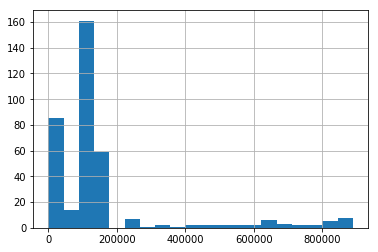

In [4]:
# Investigate patterns in the amount of missing data in each column.
col_na.hist(bins=20);

In [5]:
# Remove columns which have > 200000 missing values
cols_to_drop = azdias.columns[col_na > 200000]
print(cols_to_drop)
azdias.drop(cols_to_drop, axis=1, inplace = True)
azdias.shape

Index(['AGER_TYP', 'ALTER_HH', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3',
       'ALTER_KIND4', 'ALTERSKATEGORIE_FEIN', 'D19_BANKEN_ANZ_12',
       'D19_BANKEN_ANZ_24', 'D19_BANKEN_DATUM', 'D19_BANKEN_OFFLINE_DATUM',
       'D19_BANKEN_ONLINE_DATUM', 'D19_BANKEN_ONLINE_QUOTE_12',
       'D19_GESAMT_ANZ_12', 'D19_GESAMT_ANZ_24', 'D19_GESAMT_DATUM',
       'D19_GESAMT_OFFLINE_DATUM', 'D19_GESAMT_ONLINE_DATUM',
       'D19_GESAMT_ONLINE_QUOTE_12', 'D19_KONSUMTYP',
       'D19_LETZTER_KAUF_BRANCHE', 'D19_LOTTO', 'D19_SOZIALES',
       'D19_TELKO_ANZ_12', 'D19_TELKO_ANZ_24', 'D19_TELKO_DATUM',
       'D19_TELKO_OFFLINE_DATUM', 'D19_TELKO_ONLINE_DATUM',
       'D19_TELKO_ONLINE_QUOTE_12', 'D19_VERSAND_ANZ_12', 'D19_VERSAND_ANZ_24',
       'D19_VERSAND_DATUM', 'D19_VERSAND_OFFLINE_DATUM',
       'D19_VERSAND_ONLINE_DATUM', 'D19_VERSAND_ONLINE_QUOTE_12',
       'D19_VERSI_ANZ_12', 'D19_VERSI_ANZ_24', 'D19_VERSI_ONLINE_QUOTE_12',
       'EXTSEL992', 'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3'

(891221, 319)

The azdias dataframe originally had 366 columns and now has 319 columns, meaning that 47 columns (13%) were dropped from the dataframe based on having >200000 NaNs.  Many of these columns start with "D19" which have to do with transaction activity.  

In [6]:
# How much data is missing in each row of the dataset?
# Create series containing number of missing rows and print a few rows
row_na = azdias.shape[1] - azdias.count(axis = 1)
row_na.head()

0    233
1      0
2      0
3      4
4      0
dtype: int64

In [7]:
# Generate descriptive statistics on number of missing rows
row_na.describe()

count    891221.000000
mean         30.067767
std          71.995554
min           0.000000
25%           0.000000
50%           0.000000
75%           3.000000
max         242.000000
dtype: float64

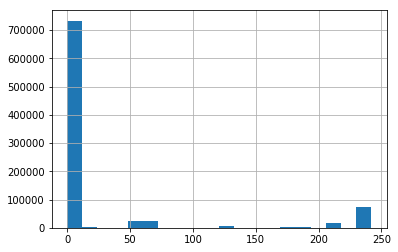

In [8]:
# Plot histogram of number of missing values
row_na.hist(bins=20);

In [9]:
# Remove rows which contain more than 10 missing values per row
rows_to_drop = azdias.index[row_na > 10]
azdias.drop(rows_to_drop, axis=0, inplace = True)
azdias.shape

(732489, 319)

The azdias dataframe originally had 891221 rows and now has 732489 rows, meaning that 158732 rows (18%) were dropped from the dataframe based on having > 10 NaNs.

In [10]:
azdias.head()

LNR  AKT_DAT_KL  ANZ_HAUSHALTE_AKTIV  ANZ_HH_TITEL  ANZ_KINDER  \
1  910220.0         9.0                 11.0           0.0         0.0   
2  910225.0         9.0                 10.0           0.0         0.0   
3  910226.0         1.0                  1.0           0.0         0.0   
4  910241.0         1.0                  3.0           0.0         0.0   
5  910244.0         1.0                  5.0           0.0         0.0   

   ANZ_PERSONEN  ANZ_STATISTISCHE_HAUSHALTE  ANZ_TITEL  ARBEIT  BALLRAUM  \
1           2.0                        12.0        0.0     3.0       6.0   
2           1.0                         7.0        0.0     3.0       2.0   
3           0.0                         2.0        0.0     2.0       4.0   
4           4.0                         3.0        0.0     4.0       2.0   
5           1.0                         2.0        0.0     2.0       6.0   

           ...           VHN VK_DHT4A VK_DISTANZ  VK_ZG11  W_KEIT_KIND_HH  \
1          ...           4.0      8.0       11.0     10.0             3.0   
2          ...           2.0      9.0        9.0      6.0             3.0   
3          ...           0.0      7.0       10.0     11.0             NaN   
4          ...           2.0      3.0        5.0      4.0             2.0   
5          ...           2.0     10.0        7.0      4.0             6.0   

   WOHNDAUER_2008  WOHNLAGE  ZABEOTYP  ANREDE_KZ  ALTERSKATEGORIE_GROB  
1             9.0       4.0       5.0        2.0                   1.0  
2             9.0       2.0       5.0        2.0                   3.0  
3             9.0       7.0       3.0        2.0                   4.0  
4             9.0       3.0       4.0        1.0                   3.0  
5             9.0       7.0       4.0        2.0                   1.0  

[5 rows x 319 columns]

<a id='part0reencode'></a>
### Select and Re-Encode Features

Info from the Term 1 project: Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. 

- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

For this project we are not supplied with a column that encodes how the data is encoded therefore I manually looked through the 
Attributes excel sheet and noted down which columns looked like either categorical or mixed and saved them into the variable "categorical" below.  

In [11]:
categorical = ['AGER_TYP', 'ANREDE_KZ', 'BIP_FLAG', 'CAMEO_DEU_2015', 'CAMEO_DEUINTL_2015', 'CJT_GESAMTTYP',
'D19_KONSUMTYP', 'D19_KK_KUNDENTYP', 'FINANZTYP', 'GEBAEUDETYP', 'GEBAEUDETYP_RASTER', 'GFK_URLAUBERTYP',
'HAUSHALTSSTRUKTUR', 'HEALTH_TYP', 'KBA05_HERSTTEMP', 'KBA05_MAXHERST', 'KBA05_MODTEMP', 'LP_FAMILIE_FEIN',
'LP_FAMILIE_GROB', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB',
'NATIONALITAET_KZ', 'OST_WEST_KZ', 'PRAEGENDE_JUGENDJAHRE', 'SHOPPER_TYP', 'SOHO_FLAG', 'TITEL_KZ', 'VERS_TYP']

In [12]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

# For every column which is encoded as "categorical" in the feat_info dataset
# print the value counts
        
for i in categorical:
    if i in azdias.columns:
        print(azdias[i].value_counts())

2.0    381860
1.0    350629
Name: ANREDE_KZ, dtype: int64
6B    53656
8A    50490
4C    43671
2D    32660
7A    32410
3C    32326
3D    31947
8B    31078
4A    30043
8C    29976
9D    26589
9B    25763
7B    22793
9C    22785
9A    19953
2C    17620
8D    16584
6E    15485
5D    13976
2B    13945
6C    13789
2A    11824
1D    11383
1A    10097
5A     9663
5B     9628
5C     8993
4B     8232
7C     8082
4D     8008
6A     6377
3A     5828
6D     5723
3B     5669
6F     5027
4E     4977
1E     4758
7D     4402
7E     4346
1C     3989
5F     3912
9E     3825
1B     3792
5E     3227
XX      282
Name: CAMEO_DEU_2015, dtype: int64
4.0    182228
3.0    135120
2.0    133711
5.0    104670
6.0     92035
1.0     84725
Name: CJT_GESAMTTYP, dtype: int64
6.0    277499
1.0    182264
5.0     97317
2.0     93587
4.0     52173
3.0     29649
Name: FINANZTYP, dtype: int64
1.0    419425
3.0    162109
8.0    145347
2.0      4231
4.0       820
6.0       556
5.0         1
Name: GEBAEUDETYP, dtype: int64
4.0  

In [13]:
# The only binary categorical variable that does not take 
# integer values is OST_WEST_KZ which uses either W or O
# will be re-encoded with 1 and 0.  Other binary categorical
# variables will be lest as is. 

azdias['OST_WEST_KZ'].replace(['W', 'O'], [1, 0], inplace=True)
azdias['OST_WEST_KZ'].head()

1    1
2    1
3    1
4    1
5    1
Name: OST_WEST_KZ, dtype: int64

In [14]:
# If column has less than 10 levels, re-encode using dummy variables.
# If column has equal to or more than 10 different values, drop for
# simplicity. Make lists of these columns to be used below.

cat_cols_to_drop = ['CAMEO_DEU_2015', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_LEBENSPHASE_FEIN', 
                   'LP_LEBENSPHASE_GROB', 'LP_STATUS_FEIN', 'PRAEGENDE_JUGENDJAHRE']

cat_cols_to_dummy = ['CJT_GESAMTTYP', 'FINANZTYP', 'GEBAEUDETYP', 'GEBAEUDETYP_RASTER', 'HEALTH_TYP', 
                    'KBA05_HERSTTEMP', 'KBA05_MAXHERST', 'KBA05_MODTEMP', 'LP_FAMILIE_GROB', 'LP_STATUS_GROB',
                    'NATIONALITAET_KZ', 'SHOPPER_TYP', 'VERS_TYP']

In [15]:
# Drop categorical columns with 10 or more values
azdias.drop(cat_cols_to_drop, axis=1, inplace = True)
azdias.shape

(732489, 312)

In [16]:
# Create dummy variables for columns with less than 10 
# unique values then drop the original columns
for col in cat_cols_to_dummy:
    dummy = pd.get_dummies(azdias[col], prefix = col)
    azdias = pd.concat([azdias, dummy], axis = 1)

print(azdias.shape)

azdias.drop(cat_cols_to_dummy, axis=1, inplace = True)

azdias.shape

(732489, 375)


(732489, 362)

In [17]:
# View first few lines of the altered dataset (including the dummary variables at
# the end of the dataframe)
azdias.head()

LNR  AKT_DAT_KL  ANZ_HAUSHALTE_AKTIV  ANZ_HH_TITEL  ANZ_KINDER  \
1  910220.0         9.0                 11.0           0.0         0.0   
2  910225.0         9.0                 10.0           0.0         0.0   
3  910226.0         1.0                  1.0           0.0         0.0   
4  910241.0         1.0                  3.0           0.0         0.0   
5  910244.0         1.0                  5.0           0.0         0.0   

   ANZ_PERSONEN  ANZ_STATISTISCHE_HAUSHALTE  ANZ_TITEL  ARBEIT  BALLRAUM  \
1           2.0                        12.0        0.0     3.0       6.0   
2           1.0                         7.0        0.0     3.0       2.0   
3           0.0                         2.0        0.0     2.0       4.0   
4           4.0                         3.0        0.0     4.0       2.0   
5           1.0                         2.0        0.0     2.0       6.0   

       ...      LP_STATUS_GROB_5.0 NATIONALITAET_KZ_1.0  NATIONALITAET_KZ_2.0  \
1      ...                       0                    1                     0   
2      ...                       0                    1                     0   
3      ...                       0                    1                     0   
4      ...                       0                    1                     0   
5      ...                       0                    1                     0   

   NATIONALITAET_KZ_3.0  SHOPPER_TYP_0.0  SHOPPER_TYP_1.0  SHOPPER_TYP_2.0  \
1                     0                0                0                0   
2                     0                0                0                1   
3                     0                0                1                0   
4                     0                0                0                1   
5                     0                1                0                0   

   SHOPPER_TYP_3.0  VERS_TYP_1.0  VERS_TYP_2.0  
1                1             0             1  
2                0             1             0  
3                0             1             0  
4                0             0             1  
5                0             0             1  

[5 rows x 362 columns]

<a id='part0clean'></a> 
### Create a Cleaning Function

Create a cleaning function with the steps that were performed on the azdias dataframe so they can also be apploed to the customer demographics data. 

In [3]:
# Create a cleaning function so the same changes can be 
# easily done on the customer dataset as it was on the
# general population dataset.  Since above I performed 
# various creations of dummy variables and droppings of 
# columns, these were simplified so that they are all 
# performed at the same time.

def clean_data(df1, df2):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: 
        df1: Customer demographics DataFrame
        df2: Unknowns DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    for col in df1.columns:
        if df1[col].dtype == np.int64:
            df1[col] = df1[col].astype(np.float64)
        
    # convert missing value codes into NaNs, ...
    for row in unknowns['attribute']:
        if row in df1.columns:
            na_map = unknowns.loc[unknowns['attribute'] == row, 'missing_or_unknown'].iloc[0]
            na_idx = df1.loc[:, row].isin(na_map)
            df1.loc[na_idx, row] = np.NaN
        else:
            continue
            
    # remove selected columns, ...
    # These columns were the ones above that had
    # > 200000 missing values in the azdias dataframe
    cols_to_drop = ['AGER_TYP', 'ALTER_HH', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3',
       'ALTER_KIND4', 'ALTERSKATEGORIE_FEIN', 'D19_BANKEN_ANZ_12',
       'D19_BANKEN_ANZ_24', 'D19_BANKEN_DATUM', 'D19_BANKEN_OFFLINE_DATUM',
       'D19_BANKEN_ONLINE_DATUM', 'D19_BANKEN_ONLINE_QUOTE_12',
       'D19_GESAMT_ANZ_12', 'D19_GESAMT_ANZ_24', 'D19_GESAMT_DATUM',
       'D19_GESAMT_OFFLINE_DATUM', 'D19_GESAMT_ONLINE_DATUM',
       'D19_GESAMT_ONLINE_QUOTE_12', 'D19_KONSUMTYP',
       'D19_LETZTER_KAUF_BRANCHE', 'D19_LOTTO', 'D19_SOZIALES',
       'D19_TELKO_ANZ_12', 'D19_TELKO_ANZ_24', 'D19_TELKO_DATUM',
       'D19_TELKO_OFFLINE_DATUM', 'D19_TELKO_ONLINE_DATUM',
       'D19_TELKO_ONLINE_QUOTE_12', 'D19_VERSAND_ANZ_12', 'D19_VERSAND_ANZ_24',
       'D19_VERSAND_DATUM', 'D19_VERSAND_OFFLINE_DATUM',
       'D19_VERSAND_ONLINE_DATUM', 'D19_VERSAND_ONLINE_QUOTE_12',
       'D19_VERSI_ANZ_12', 'D19_VERSI_ANZ_24', 'D19_VERSI_ONLINE_QUOTE_12',
       'EXTSEL992', 'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4',
       'KBA05_BAUMAX', 'KBA05_MAXVORB', 'KK_KUNDENTYP', 'TITEL_KZ']
    df1.drop(cols_to_drop, axis=1, inplace = True)
    
    # remove selected rows, ...
    # These are rows which have >25 missing values
    row_na = df1.shape[1] - df1.count(axis = 1)
    rows_to_drop = df1.index[row_na > 10]
    df1.drop(rows_to_drop, axis=0, inplace = True)
    
    # select, re-encode, and engineer column values
    df1['OST_WEST_KZ'].replace(['W', 'O'], [1, 0], inplace=True)

    cols_to_dummy = ['CJT_GESAMTTYP', 'FINANZTYP', 'GEBAEUDETYP', 'GEBAEUDETYP_RASTER', 'HEALTH_TYP', 
                    'KBA05_HERSTTEMP', 'KBA05_MAXHERST', 'KBA05_MODTEMP', 'LP_FAMILIE_GROB', 'LP_STATUS_GROB',
                    'NATIONALITAET_KZ', 'SHOPPER_TYP', 'VERS_TYP']
    
    for col in cols_to_dummy:
        dummy = pd.get_dummies(df1[col], prefix = col)
        df1 = pd.concat([df1, dummy], axis = 1)
        
    df1.drop(cols_to_dummy, axis=1, inplace = True)
    
    cols_to_drop = ['CAMEO_DEU_2015', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_LEBENSPHASE_FEIN', 
                   'LP_LEBENSPHASE_GROB', 'LP_STATUS_FEIN', 'PRAEGENDE_JUGENDJAHRE']
    
    df1.drop(cols_to_drop, axis=1, inplace = True)
    
    # Return the cleaned dataframe.
    return df1

In [19]:
# load in the customers dataset 
customers = pd.read_csv('customers.csv')
del customers['Unnamed: 0']

C:\Users\ursula\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [20]:
# Determine the shape of the customers dataframe
customers.shape

(191652, 369)

In [21]:
# View the first few lines of the customers dataframe
customers.head()

LNR  AGER_TYP  AKT_DAT_KL  ALTER_HH  ALTER_KIND1  ALTER_KIND2  \
0    9626         2         1.0      10.0          NaN          NaN   
1    9628        -1         9.0      11.0          NaN          NaN   
2  143872        -1         1.0       6.0          NaN          NaN   
3  143873         1         1.0       8.0          NaN          NaN   
4  143874        -1         1.0      20.0          NaN          NaN   

   ALTER_KIND3  ALTER_KIND4  ALTERSKATEGORIE_FEIN  ANZ_HAUSHALTE_AKTIV  \
0          NaN          NaN                  10.0                  1.0   
1          NaN          NaN                   NaN                  NaN   
2          NaN          NaN                   0.0                  1.0   
3          NaN          NaN                   8.0                  0.0   
4          NaN          NaN                  14.0                  7.0   

          ...           VK_ZG11  W_KEIT_KIND_HH  WOHNDAUER_2008  WOHNLAGE  \
0         ...               2.0             6.0             9.0       7.0   
1         ...               3.0             0.0             9.0       NaN   
2         ...              11.0             6.0             9.0       2.0   
3         ...               2.0             NaN             9.0       7.0   
4         ...               4.0             2.0             9.0       3.0   

   ZABEOTYP      PRODUCT_GROUP  CUSTOMER_GROUP ONLINE_PURCHASE ANREDE_KZ  \
0         3  COSMETIC_AND_FOOD     MULTI_BUYER               0         1   
1         3               FOOD    SINGLE_BUYER               0         1   
2         3  COSMETIC_AND_FOOD     MULTI_BUYER               0         2   
3         1           COSMETIC     MULTI_BUYER               0         1   
4         1               FOOD     MULTI_BUYER               0         1   

  ALTERSKATEGORIE_GROB  
0                    4  
1                    4  
2                    4  
3                    4  
4                    3  

[5 rows x 369 columns]

In [22]:
# Investigate the CUSTOMER_GROUP column
customers['CUSTOMER_GROUP'].value_counts()

MULTI_BUYER     132238
SINGLE_BUYER     59414
Name: CUSTOMER_GROUP, dtype: int64

In [23]:
# Investigate the ONLINE_PURCHASE column
customers['ONLINE_PURCHASE'].value_counts()

0    174356
1     17296
Name: ONLINE_PURCHASE, dtype: int64

In [24]:
# Investigate the PRODUCT_GROUP column
customers['PRODUCT_GROUP'].value_counts()

COSMETIC_AND_FOOD    100860
FOOD                  47382
COSMETIC              43410
Name: PRODUCT_GROUP, dtype: int64

In [25]:
# View count of these 3 extra columns (there are no NaNs)
customers['CUSTOMER_GROUP'].count(), customers['ONLINE_PURCHASE'].count(), customers['PRODUCT_GROUP'].count()

(191652, 191652, 191652)

In [4]:
# Reload unknowns object as saved after above analysis
unknowns = pickle.load(open("unknowns.pickle", "rb"))

In [27]:
# Run the clean_data function on the azdias dataset
customers = clean_data(customers, unknowns)

In [28]:
# Determine the shape of the customers dataframe after cleaning
customers.shape

(131204, 364)

In [29]:
# View the first few lines of the customers dataframe after cleaning
customers.head()

LNR  AKT_DAT_KL  ANZ_HAUSHALTE_AKTIV  ANZ_HH_TITEL  ANZ_KINDER  \
0    9626.0         1.0                  1.0           0.0         0.0   
2  143872.0         1.0                  1.0           0.0         0.0   
3  143873.0         1.0                  0.0           NaN         0.0   
4  143874.0         1.0                  7.0           0.0         0.0   
5  143888.0         1.0                  1.0           0.0         0.0   

   ANZ_PERSONEN  ANZ_STATISTISCHE_HAUSHALTE  ANZ_TITEL  ARBEIT  BALLRAUM  \
0           2.0                         1.0        0.0     1.0       3.0   
2           1.0                         1.0        0.0     3.0       7.0   
3           0.0                         1.0        0.0     1.0       7.0   
4           4.0                         7.0        0.0     3.0       3.0   
5           2.0                         1.0        0.0     3.0       7.0   

       ...      LP_STATUS_GROB_5.0 NATIONALITAET_KZ_1.0  NATIONALITAET_KZ_2.0  \
0      ...                       1                    1                     0   
2      ...                       1                    1                     0   
3      ...                       0                    1                     0   
4      ...                       0                    1                     0   
5      ...                       0                    1                     0   

   NATIONALITAET_KZ_3.0  SHOPPER_TYP_0.0  SHOPPER_TYP_1.0  SHOPPER_TYP_2.0  \
0                     0                0                0                0   
2                     0                0                1                0   
3                     0                1                0                0   
4                     0                0                1                0   
5                     0                0                1                0   

   SHOPPER_TYP_3.0  VERS_TYP_1.0  VERS_TYP_2.0  
0                1             1             0  
2                0             0             1  
3                0             1             0  
4                0             0             1  
5                0             0             1  

[5 rows x 364 columns]

In [30]:
# Determine the columns that are in the cleaned customers dataframe
# but not the cleaned azdias dataframe (these 3 are expected)
customers.columns[~customers.columns.isin(azdias.columns)]

Index(['PRODUCT_GROUP', 'CUSTOMER_GROUP', 'ONLINE_PURCHASE'], dtype='object')

In [31]:
# Determine the columns that are in the cleaned azdias dataframe
# but not the cleaned customers dataframe
azdias.columns[~azdias.columns.isin(customers.columns)]

Index(['GEBAEUDETYP_5.0'], dtype='object')

In [32]:
# Find index of the GEBAEUDETYP_5.0 column in the azdias dataframe
column_index = azdias.columns.get_loc("GEBAEUDETYP_5.0")
column_index

315

In [33]:
# Insert a column called GEBAEUDETYP_5.0 at index = 315
# with all values = 0
customers.insert(loc=column_index, column='GEBAEUDETYP_5.0', value=0)

In [34]:
# Determine that the number of columns match for the dataframes (taking
# into accont the extra 3 columns)
customers.shape[1] == azdias.shape[1] + 3

True

In [35]:
# Dump the azdias dataframe to a pickle object since it takes up so much room in memory.
pickle.dump(azdias, open("azdias_clean.pickle", "wb"))

# Dump the customers dataframe to a pickle object to use for later.
pickle.dump(customers, open("customers_clean.pickle", "wb"))

<a id='part0impute'></a> 
## Impute Missing Values

In [2]:
# Reload cleaned azdias object as saved after above analysis (may need to rerun imports)
azdias_clean = pickle.load(open("azdias_clean.pickle", "rb"))

# Reload cleaned customers object as saved after above analysis
customers_clean = pickle.load(open("customers_clean.pickle", "rb"))

In [3]:
# The imputer does not work at this stage because the columns CAMEO_DEUG_2015 and CAMEO_INTL_2015 
# have values that strings "X" and "XX".  EINGEFUEGT_AM has a similar issue. Remove these columns 
# for simplicity.  
del azdias_clean['CAMEO_DEUG_2015']
del azdias_clean['CAMEO_INTL_2015']
del azdias_clean['EINGEFUEGT_AM']
del customers_clean['CAMEO_DEUG_2015']
del customers_clean['CAMEO_INTL_2015']
del customers_clean['EINGEFUEGT_AM']

In [4]:
for col in azdias_clean.columns:
    print(azdias_clean[col].value_counts())

524287.0    1
814227.0    1
814249.0    1
814248.0    1
814247.0    1
814246.0    1
814245.0    1
814244.0    1
814243.0    1
814242.0    1
203560.0    1
814239.0    1
888288.0    1
203559.0    1
814235.0    1
814234.0    1
814233.0    1
814232.0    1
814231.0    1
814230.0    1
814229.0    1
814250.0    1
814251.0    1
203563.0    1
814266.0    1
203569.0    1
254159.0    1
814274.0    1
203568.0    1
198286.0    1
           ..
290043.0    1
257938.0    1
290041.0    1
290040.0    1
840688.0    1
290039.0    1
290038.0    1
290058.0    1
605497.0    1
290078.0    1
918252.0    1
290076.0    1
290075.0    1
290074.0    1
290073.0    1
290072.0    1
198833.0    1
290071.0    1
290069.0    1
877305.0    1
290060.0    1
290067.0    1
290066.0    1
290064.0    1
622379.0    1
290063.0    1
290062.0    1
290061.0    1
870821.0    1
524289.0    1
Name: LNR, Length: 732489, dtype: int64
1.0    352007
9.0    242829
5.0     25329
6.0     24685
3.0     21827
4.0     18824
7.0     18418
8.0     

0.0    629741
3.0     40257
6.0     18382
5.0     17409
2.0     14556
7.0      4853
1.0      4254
4.0      3037
Name: D19_SCHUHE, dtype: int64
0.0    384196
6.0    200499
7.0     53510
3.0     39630
5.0     30990
2.0      9567
4.0      8995
1.0      5102
Name: D19_SONSTIGE, dtype: int64
0.0    495925
6.0    173280
7.0     37806
5.0     12696
3.0      9757
4.0      1613
2.0       996
1.0       416
Name: D19_TECHNIK, dtype: int64
0.0    585206
6.0    104207
3.0     14724
5.0     12740
7.0      7532
4.0      3214
2.0      3132
1.0      1734
Name: D19_TELKO_MOBILE, dtype: int64
0.0    621201
6.0     78566
5.0     13726
3.0     10220
7.0      5043
4.0      2129
2.0      1223
1.0       381
Name: D19_TELKO_REST, dtype: int64
0.0    697937
6.0     17896
7.0      7011
3.0      5345
5.0      3372
2.0       481
4.0       407
1.0        40
Name: D19_TIERARTIKEL, dtype: int64
0.0    593752
6.0     61253
3.0     34871
5.0     22141
2.0      6682
7.0      5161
4.0      4362
1.0      4267
Name: D19_VE

3.0    220045
2.0    157828
4.0    129022
1.0     96533
5.0     79426
0.0     49635
Name: KBA05_MOD4, dtype: int64
0.0    218420
1.0    214499
2.0    213685
3.0     85885
Name: KBA05_MOD8, dtype: int64
3.0    285667
2.0    219224
1.0    119429
4.0    108169
Name: KBA05_MOTOR, dtype: int64
1.0    385147
0.0    201063
2.0     73153
3.0     73126
Name: KBA05_MOTRAD, dtype: int64
1.0    247754
0.0    242684
2.0    183372
3.0     58679
Name: KBA05_SEG1, dtype: int64
2.0    264069
1.0    149650
3.0    146385
0.0    110048
4.0     62337
Name: KBA05_SEG10, dtype: int64
3.0    296398
4.0    161905
2.0    150224
1.0     68201
5.0     55761
Name: KBA05_SEG2, dtype: int64
3.0    267478
2.0    181658
4.0    161801
1.0     61279
5.0     60273
Name: KBA05_SEG3, dtype: int64
3.0    318348
2.0    150361
4.0    141791
1.0     61121
5.0     60868
Name: KBA05_SEG4, dtype: int64
1.0    232013
2.0    180873
0.0    180061
3.0     89669
4.0     49873
Name: KBA05_SEG5, dtype: int64
0.0    645422
1.0     87067


3.0    304388
2.0    152123
4.0    144693
1.0     69022
5.0     62263
Name: KBA13_HERST_FORD_OPEL, dtype: int64
3.0    322158
2.0    156719
4.0    142453
5.0     56782
1.0     54377
Name: KBA13_HERST_SONST, dtype: int64
3.0    300681
4.0    198291
5.0    155909
2.0     66055
1.0     11553
Name: KBA13_HHZ, dtype: int64
3.0    260295
1.0    223216
0.0     88544
4.0     86733
5.0     67419
2.0      6282
Name: KBA13_KMH_0_140, dtype: int64
1.0    588853
3.0     87727
2.0     55909
Name: KBA13_KMH_110, dtype: int64
1.0    237695
4.0    189114
3.0    150652
2.0     84927
5.0     70101
Name: KBA13_KMH_140, dtype: int64
3.0    336844
2.0    167449
4.0    123734
1.0     68751
5.0     35711
Name: KBA13_KMH_140_210, dtype: int64
3.0    331395
2.0    158356
4.0    145979
1.0     56954
5.0     39805
Name: KBA13_KMH_180, dtype: int64
3.0    336937
4.0    153406
2.0    150988
5.0     51227
1.0     39931
Name: KBA13_KMH_210, dtype: int64
3.0    258498
2.0    150827
0.0    131342
4.0     82268
5.0     

6.0    185677
5.0    138841
3.0     87921
2.0     86558
7.0     77471
4.0     64379
1.0     50946
Name: REGIOTYP, dtype: int64
3.0    252891
5.0    162843
1.0    128086
2.0     95354
4.0     89570
Name: RELAT_AB, dtype: int64
5.0    260615
3.0    159678
1.0    115121
4.0    111364
2.0     85711
Name: RETOURTYP_BK_S, dtype: int64
5.0    188188
3.0    160937
4.0    139201
2.0    123357
1.0    120806
Name: RT_KEIN_ANREIZ, dtype: int64
5.0    300781
4.0    157876
3.0    119368
2.0    105221
1.0     49243
Name: RT_SCHNAEPPCHEN, dtype: int64
5.0    160362
4.0    144698
3.0    137549
2.0    134311
1.0    133606
0.0     21266
Name: RT_UEBERGROESSE, dtype: int64
5.0    172229
7.0    154412
4.0    117434
3.0     88225
6.0     81608
2.0     76666
1.0     41915
Name: SEMIO_DOM, dtype: int64
4.0    170574
7.0    162422
6.0    125208
3.0     96920
2.0     74697
5.0     67946
1.0     34722
Name: SEMIO_ERL, dtype: int64
2.0    131421
5.0    125302
4.0    123061
7.0    105888
6.0     92704
3.0     9003

0    572533
1    159956
Name: SHOPPER_TYP_3.0, dtype: int64
0    401514
1    330975
Name: VERS_TYP_1.0, dtype: int64
1    368011
0    364478
Name: VERS_TYP_2.0, dtype: int64


In [5]:
azdias_clean.shape, customers_clean.shape

((732489, 359), (131204, 362))

In [6]:
# Make a new dataframe to hold the 3 extra columns of the customers dataset in case we need 
# them for later
customers_extra_cols = customers_clean[['PRODUCT_GROUP', 'CUSTOMER_GROUP', 'ONLINE_PURCHASE']]
customers_extra_cols.head()

PRODUCT_GROUP CUSTOMER_GROUP  ONLINE_PURCHASE
0  COSMETIC_AND_FOOD    MULTI_BUYER              0.0
2  COSMETIC_AND_FOOD    MULTI_BUYER              0.0
3           COSMETIC    MULTI_BUYER              0.0
4               FOOD    MULTI_BUYER              0.0
5  COSMETIC_AND_FOOD    MULTI_BUYER              0.0

In [7]:
# Delete the 3 extra columns from the customers dataframe so it has the same columns
# as the azdias dataframe
del customers_clean['PRODUCT_GROUP']
del customers_clean['CUSTOMER_GROUP']
del customers_clean['ONLINE_PURCHASE']
customers_clean.shape

(131204, 359)

In [8]:
# Impute the missing values using the mean 
imputer = Imputer()
azdias_clean = pd.DataFrame(imputer.fit_transform(azdias_clean), columns = azdias_clean.columns)
customers_clean = pd.DataFrame(imputer.transform(customers_clean), columns = customers_clean.columns)

C:\Users\ursula\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [9]:
# View number of NaNs per column of the azdias_clean df (now all should be 0)
(azdias_clean.shape[0] - azdias_clean.count()).sort_values()

LNR                     0
KOMBIALTER              0
KKK                     0
KBA13_VW                0
KBA13_VORB_3            0
KBA13_VORB_2            0
KBA13_VORB_1_2          0
KBA13_VORB_1            0
KBA13_VORB_0            0
KONSUMNAEHE             0
KBA13_TOYOTA            0
KBA13_SITZE_5           0
KBA13_SITZE_4           0
KBA13_SEG_WOHNMOBILE    0
KBA13_SEG_VAN           0
KBA13_SEG_UTILITIES     0
KBA13_SEG_SPORTWAGEN    0
KBA13_SEG_SONSTIGE      0
KBA13_SEG_OBERKLASSE    0
KBA13_SITZE_6           0
KONSUMZELLE             0
MIN_GEBAEUDEJAHR        0
MOBI_RASTER             0
SEMIO_ERL               0
SEMIO_DOM               0
RT_UEBERGROESSE         0
RT_SCHNAEPPCHEN         0
RT_KEIN_ANREIZ          0
RETOURTYP_BK_S          0
RELAT_AB                0
                       ..
KBA05_KRSZUL            0
KBA05_KRSVAN            0
KBA05_KRSOBER           0
KBA05_KRSKLEIN          0
KBA05_KRSHERST3         0
KBA05_MAXAH             0
KBA05_SEG10             0
KBA05_SEG2  

In [10]:
# View number of NaNs per column of the customers_clean df (now all should be 0)
(customers_clean.shape[0] - customers_clean.count()).sort_values()

LNR                     0
KOMBIALTER              0
KKK                     0
KBA13_VW                0
KBA13_VORB_3            0
KBA13_VORB_2            0
KBA13_VORB_1_2          0
KBA13_VORB_1            0
KBA13_VORB_0            0
KONSUMNAEHE             0
KBA13_TOYOTA            0
KBA13_SITZE_5           0
KBA13_SITZE_4           0
KBA13_SEG_WOHNMOBILE    0
KBA13_SEG_VAN           0
KBA13_SEG_UTILITIES     0
KBA13_SEG_SPORTWAGEN    0
KBA13_SEG_SONSTIGE      0
KBA13_SEG_OBERKLASSE    0
KBA13_SITZE_6           0
KONSUMZELLE             0
MIN_GEBAEUDEJAHR        0
MOBI_RASTER             0
SEMIO_ERL               0
SEMIO_DOM               0
RT_UEBERGROESSE         0
RT_SCHNAEPPCHEN         0
RT_KEIN_ANREIZ          0
RETOURTYP_BK_S          0
RELAT_AB                0
                       ..
KBA05_KRSZUL            0
KBA05_KRSVAN            0
KBA05_KRSOBER           0
KBA05_KRSKLEIN          0
KBA05_KRSHERST3         0
KBA05_MAXAH             0
KBA05_SEG10             0
KBA05_SEG2  

<a id='part0scaling'></a> 
## Apply Feature Scaling

In [11]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
azdias_clean = pd.DataFrame(scaler.fit_transform(azdias_clean), columns = azdias_clean.columns)
customers_clean = pd.DataFrame(scaler.transform(customers_clean), columns = customers_clean.columns)

In [12]:
azdias_clean.head()

LNR  AKT_DAT_KL  ANZ_HAUSHALTE_AKTIV  ANZ_HH_TITEL  ANZ_KINDER  \
0  1.057832    1.259540             0.186291     -0.125909   -0.298802   
1  1.057852    1.259540             0.120134     -0.125909   -0.298802   
2  1.057855   -0.936066            -0.475280     -0.125909   -0.298802   
3  1.057914   -0.936066            -0.342966     -0.125909   -0.298802   
4  1.057925   -0.936066            -0.210651     -0.125909   -0.298802   

   ANZ_PERSONEN  ANZ_STATISTISCHE_HAUSHALTE  ANZ_TITEL    ARBEIT  BALLRAUM  \
0      0.225900                    0.334761  -0.060501 -0.179709  0.850294   
1     -0.633544                   -0.032342  -0.060501 -0.179709 -0.980004   
2     -1.492988                   -0.399445  -0.060501 -1.185501 -0.064855   
3      1.944788                   -0.326025  -0.060501  0.826083 -0.980004   
4     -0.633544                   -0.399445  -0.060501 -1.185501  0.850294   

       ...       LP_STATUS_GROB_5.0  NATIONALITAET_KZ_1.0  \
0      ...                -0.408334              0.442039   
1      ...                -0.408334              0.442039   
2      ...                -0.408334              0.442039   
3      ...                -0.408334              0.442039   
4      ...                -0.408334              0.442039   

   NATIONALITAET_KZ_2.0  NATIONALITAET_KZ_3.0  SHOPPER_TYP_0.0  \
0             -0.295954             -0.205922        -0.448785   
1             -0.295954             -0.205922        -0.448785   
2             -0.295954             -0.205922        -0.448785   
3             -0.295954             -0.205922        -0.448785   
4             -0.295954             -0.205922         2.228237   

   SHOPPER_TYP_1.0  SHOPPER_TYP_2.0  SHOPPER_TYP_3.0  VERS_TYP_1.0  \
0        -0.658768        -0.601389         1.891908     -0.907919   
1        -0.658768         1.662818        -0.528567      1.101419   
2         1.517985        -0.601389        -0.528567      1.101419   
3        -0.658768         1.662818        -0.528567     -0.907919   
4        -0.658768        -0.601389        -0.528567     -0.907919   

   VERS_TYP_2.0  
0      0.995188  
1     -1.004835  
2     -1.004835  
3      0.995188  
4      0.995188  

[5 rows x 359 columns]

In [13]:
customers_clean.head()

LNR  AKT_DAT_KL  ANZ_HAUSHALTE_AKTIV  ANZ_HH_TITEL  ANZ_KINDER  \
0 -2.436123   -0.936066            -0.475280     -0.125909   -0.298802   
1 -1.915300   -0.936066            -0.475280     -0.125909   -0.298802   
2 -1.915297   -0.936066            -0.541437      0.000000   -0.298802   
3 -1.915293   -0.936066            -0.078337     -0.125909   -0.298802   
4 -1.915238   -0.936066            -0.475280     -0.125909   -0.298802   

   ANZ_PERSONEN  ANZ_STATISTISCHE_HAUSHALTE  ANZ_TITEL    ARBEIT  BALLRAUM  \
0      0.225900                   -0.472866  -0.060501 -2.191293 -0.522430   
1     -0.633544                   -0.472866  -0.060501 -0.179709  1.307869   
2     -1.492988                   -0.472866  -0.060501 -2.191293  1.307869   
3      1.944788                   -0.032342  -0.060501 -0.179709 -0.522430   
4      0.225900                   -0.472866  -0.060501 -0.179709  1.307869   

       ...       LP_STATUS_GROB_5.0  NATIONALITAET_KZ_1.0  \
0      ...                 2.448975              0.442039   
1      ...                 2.448975              0.442039   
2      ...                -0.408334              0.442039   
3      ...                -0.408334              0.442039   
4      ...                -0.408334              0.442039   

   NATIONALITAET_KZ_2.0  NATIONALITAET_KZ_3.0  SHOPPER_TYP_0.0  \
0             -0.295954             -0.205922        -0.448785   
1             -0.295954             -0.205922        -0.448785   
2             -0.295954             -0.205922         2.228237   
3             -0.295954             -0.205922        -0.448785   
4             -0.295954             -0.205922        -0.448785   

   SHOPPER_TYP_1.0  SHOPPER_TYP_2.0  SHOPPER_TYP_3.0  VERS_TYP_1.0  \
0        -0.658768        -0.601389         1.891908      1.101419   
1         1.517985        -0.601389        -0.528567     -0.907919   
2        -0.658768        -0.601389        -0.528567      1.101419   
3         1.517985        -0.601389        -0.528567     -0.907919   
4         1.517985        -0.601389        -0.528567     -0.907919   

   VERS_TYP_2.0  
0     -1.004835  
1      0.995188  
2     -1.004835  
3      0.995188  
4      0.995188  

[5 rows x 359 columns]

**Imputation and Standard Scaling Discussion**

https://stats.stackexchange.com/questions/143700/which-is-better-replacement-by-mean-and-replacement-by-median

I chose to impute the missing values using the mean of the columns.  This method is not ideal - the imputed values are inaccurate, and all the missing values are given the same value so there will be a spike in that value.  We can ask why these data are missing in the first place.  According to the StackExchange post listed above, multiple imputation, and "Model-based imputations are demonstrably superior and less biasing than any automated approach" and could give better results.  

Feature scaling was performed using StandardScaler.

In [14]:
# Dump the azdias dataframe to a pickle object since it takes up so much room in memory.
pickle.dump(azdias_clean, open("azdias_final.pickle", "wb"))

# Dump the customers dataframe to a pickle object to use for later.
pickle.dump(customers_clean, open("customers_final.pickle", "wb"))

<a id='part1'></a>
## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [2]:
# Reload cleaned azdias object as saved after above analysis (may need to rerun imports)
azdias_final = pickle.load(open("azdias_final.pickle", "rb"))

# Reload cleaned customers object as saved after above analysis
customers_final = pickle.load(open("customers_final.pickle", "rb"))

<a id='part1pca'></a> 
### Perform Dimensionality Reduction

From Term 1 project: On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [3]:
# do_pca function was taken from class notes and altered

def do_pca(n_components, data):
    '''
    Transforms data using PCA to create n_components, and provides back the results of the
    transformation.

    INPUT: n_components - int - the number of principal components to create
           data - the data you would like to transform

    OUTPUT: pca - the pca object created after fitting the data
            X_pca - the transformed X matrix with new number of components
    '''
    pca = PCA(n_components)
    X_pca = pca.fit_transform(data)
    return pca, X_pca

In [6]:
# Apply PCA to the data not setting a value for the # of components
azdias_pca_all, azdias_X_pca_all = do_pca(None, azdias_final)

In [7]:
# The scree_plot function was taken from class notes.

def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

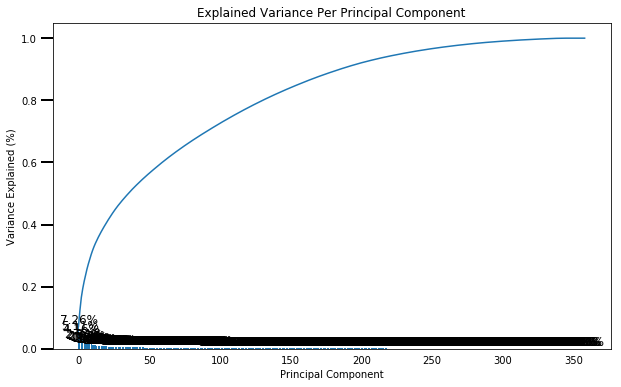

In [10]:
# Investigate the variance accounted for by each principal component
# when all components are calculated
scree_plot(azdias_pca_all)

In [12]:
# Re-apply PCA to the data while selecting to retain 200 components.
azdias_pca_200, azdias_X_pca_200 = do_pca(200, azdias_final)

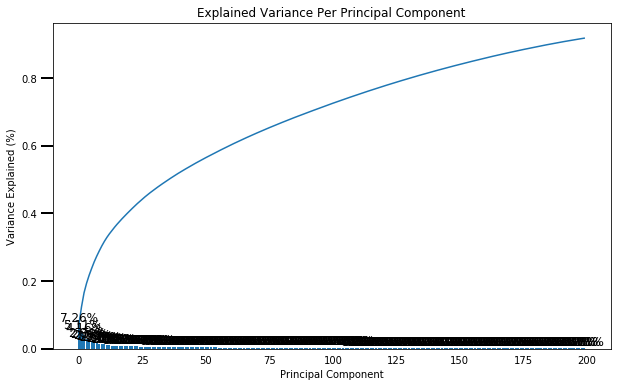

In [13]:
# Investigate the variance accounted for by each principal component
# when 20 components are used
scree_plot(azdias_pca_200)

There is no clear cut way to choose the number of components to keep when performing PCA. By looking around forums as well as this teaching document (http://www.octoberraindrops.com/publications/Phan_2016_IntroductionToPCA.pdf), it has been suggested to keep the number of components which captures at least 85% of the variability of the data.  In addition, another way to decide on the number of components is to look at the "elbow", or where the scree plot line curves such that you begin to get diminishing returnings of the amount of variance explained per addition of an additional component.  Therefore, based on these 2 ideas, I have chosen to use 200 components which explains ~90% of the variance (which is at over 85%, and at this point the line on the scree plot starts to plateau). 

<a id='part1interpretPCA'></a> 
### Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the i-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [31]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

# The pca_results function was taken from the class notes and altered

def pca_results(full_dataset, pca, component_number):
    '''
    Create a DataFrame of the PCA results
    Includes dimension feature weights and explained variance
    Visualizes the PCA results where figure 1 shows all features sorted
    and figure 2 shows the top 3 negative and positive features.
    '''

    # Dimension indexing
    dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = full_dataset.keys())
    components.index = dimensions

    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions
    
    # Create a bar plot visualization for 1st figure (all columns sorted)
    fig1, ax1 = plt.subplots(figsize = (15,8))

    # Plot the feature weights as a function of the components
    components.iloc[component_number-1, :].sort_values().plot(ax = ax1, kind = 'bar');
    ax1.set_ylabel("Feature Weights")
    ax1.set_xticklabels(components.iloc[component_number-1, :].sort_values().index, rotation=90)
   
    # Create a bar plot visualization for 2nd figure (top and bottom 3 columns)
    fig2, ax2 = plt.subplots(figsize = (6,3))
    
    # Plot the feature weights as a function of the components
    components.iloc[component_number-1, :].sort_values().iloc[[0, 1, 2, -3, -2, -1]].plot(ax = ax2, kind = 'bar');
    ax2.set_ylabel("Feature Weights")
    ax2.set_xticklabels(components.iloc[component_number-1, :].sort_values().index, rotation=90)

    # Return a concatenated DataFrame
    return pd.concat([variance_ratios, components], axis = 1)

Explained Variance     LNR  AKT_DAT_KL  ANZ_HAUSHALTE_AKTIV  \
Dimension 1                0.0726 -0.0295      0.0616               0.0832   
Dimension 2                0.0511  0.0816      0.0129               0.0192   
Dimension 3                0.0417 -0.0259     -0.0460               0.0198   
Dimension 4                0.0284 -0.0725     -0.1094               0.0104   
Dimension 5                0.0233 -0.1126      0.0599               0.0094   
Dimension 6                0.0204 -0.0126     -0.0059              -0.0025   
Dimension 7                0.0193 -0.0207     -0.0138               0.0277   
Dimension 8                0.0169 -0.0329     -0.0196               0.0063   
Dimension 9                0.0155 -0.0736      0.0275              -0.0607   
Dimension 10               0.0147  0.0468     -0.0053               0.0285   
Dimension 11               0.0133 -0.0089     -0.0104               0.0552   
Dimension 12               0.0119 -0.0389     -0.0018               0.0275   
Dimension 13               0.0106 -0.0781      0.0004               0.0988   
Dimension 14               0.0097  0.0308     -0.0051               0.0746   
Dimension 15               0.0095  0.0168     -0.0047               0.1255   
Dimension 16               0.0090 -0.0607     -0.0022              -0.0212   
Dimension 17               0.0083  0.0314      0.0054               0.0258   
Dimension 18               0.0082 -0.0124     -0.0216               0.1202   
Dimension 19               0.0079 -0.0932      0.0232               0.1027   
Dimension 20               0.0077 -0.0274     -0.0472               0.0646   
Dimension 21               0.0075 -0.0019     -0.0140              -0.0569   
Dimension 22               0.0074  0.0100     -0.0040               0.0340   
Dimension 23               0.0072 -0.0057      0.0098               0.0984   
Dimension 24               0.0071 -0.0077      0.0659               0.1244   
Dimension 25               0.0067  0.0274      0.0470              -0.0034   
Dimension 26               0.0067  0.0047      0.0364              -0.0038   
Dimension 27               0.0064 -0.0102      0.0914              -0.0412   
Dimension 28               0.0062  0.0359     -0.0105               0.0682   
Dimension 29               0.0059  0.0424      0.0236               0.0765   
Dimension 30               0.0057 -0.0131     -0.0124               0.0922   
...                           ...     ...         ...                  ...   
Dimension 171              0.0017 -0.0966     -0.1755              -0.0128   
Dimension 172              0.0016  0.0848     -0.1277              -0.0496   
Dimension 173              0.0016 -0.0167     -0.1909              -0.0892   
Dimension 174              0.0016  0.0767      0.0756              -0.0202   
Dimension 175              0.0016 -0.1604     -0.0016               0.0292   
Dimension 176              0.0016  0.0320     -0.1117              -0.1399   
Dimension 177              0.0016  0.0094     -0.0283              -0.0575   
Dimension 178              0.0016  0.1325     -0.0129              -0.0828   
Dimension 179              0.0015 -0.0413     -0.0440              -0.0286   
Dimension 180              0.0015  0.1488      0.0180               0.0236   
Dimension 181              0.0015 -0.1611      0.0216              -0.0511   
Dimension 182              0.0015 -0.1029      0.0307              -0.0262   
Dimension 183              0.0015  0.1264      0.2090              -0.0572   
Dimension 184              0.0015 -0.0250      0.1214              -0.0694   
Dimension 185              0.0015  0.0075     -0.1338              -0.0524   
Dimension 186              0.0014  0.1282      0.3463              -0.0065   
Dimension 187              0.0014 -0.1974      0.1760               0.0137   
Dimension 188              0.0014  0.0398      0.0322              -0.0233   
Dimension 189              0.0014  0.1679     -0.1081              -0.0092   
Dimension 190              0.0014 -0.

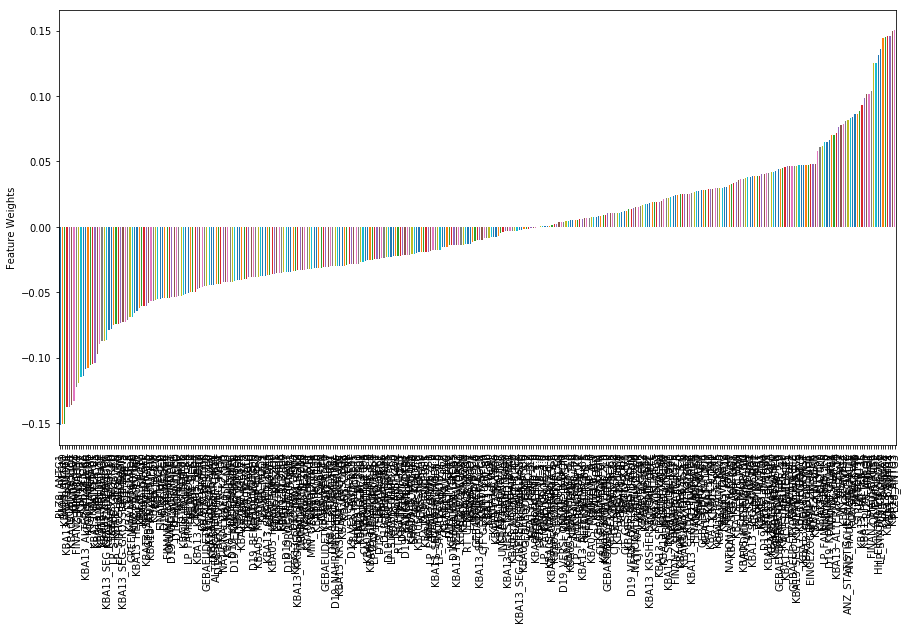

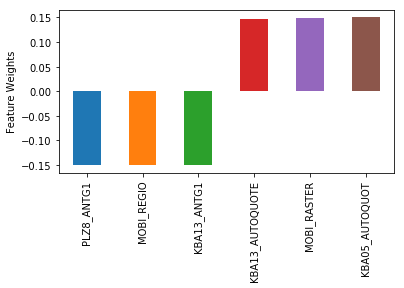

In [32]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca_results(azdias_final, azdias_pca_200, component_number = 1)

Explained Variance     LNR  AKT_DAT_KL  ANZ_HAUSHALTE_AKTIV  \
Dimension 1                0.0726 -0.0295      0.0616               0.0832   
Dimension 2                0.0511  0.0816      0.0129               0.0192   
Dimension 3                0.0417 -0.0259     -0.0460               0.0198   
Dimension 4                0.0284 -0.0725     -0.1094               0.0104   
Dimension 5                0.0233 -0.1126      0.0599               0.0094   
Dimension 6                0.0204 -0.0126     -0.0059              -0.0025   
Dimension 7                0.0193 -0.0207     -0.0138               0.0277   
Dimension 8                0.0169 -0.0329     -0.0196               0.0063   
Dimension 9                0.0155 -0.0736      0.0275              -0.0607   
Dimension 10               0.0147  0.0468     -0.0053               0.0285   
Dimension 11               0.0133 -0.0089     -0.0104               0.0552   
Dimension 12               0.0119 -0.0389     -0.0018               0.0275   
Dimension 13               0.0106 -0.0781      0.0004               0.0988   
Dimension 14               0.0097  0.0308     -0.0051               0.0746   
Dimension 15               0.0095  0.0168     -0.0047               0.1255   
Dimension 16               0.0090 -0.0607     -0.0022              -0.0212   
Dimension 17               0.0083  0.0314      0.0054               0.0258   
Dimension 18               0.0082 -0.0124     -0.0216               0.1202   
Dimension 19               0.0079 -0.0932      0.0232               0.1027   
Dimension 20               0.0077 -0.0274     -0.0472               0.0646   
Dimension 21               0.0075 -0.0019     -0.0140              -0.0569   
Dimension 22               0.0074  0.0100     -0.0040               0.0340   
Dimension 23               0.0072 -0.0057      0.0098               0.0984   
Dimension 24               0.0071 -0.0077      0.0659               0.1244   
Dimension 25               0.0067  0.0274      0.0470              -0.0034   
Dimension 26               0.0067  0.0047      0.0364              -0.0038   
Dimension 27               0.0064 -0.0102      0.0914              -0.0412   
Dimension 28               0.0062  0.0359     -0.0105               0.0682   
Dimension 29               0.0059  0.0424      0.0236               0.0765   
Dimension 30               0.0057 -0.0131     -0.0124               0.0922   
...                           ...     ...         ...                  ...   
Dimension 171              0.0017 -0.0966     -0.1755              -0.0128   
Dimension 172              0.0016  0.0848     -0.1277              -0.0496   
Dimension 173              0.0016 -0.0167     -0.1909              -0.0892   
Dimension 174              0.0016  0.0767      0.0756              -0.0202   
Dimension 175              0.0016 -0.1604     -0.0016               0.0292   
Dimension 176              0.0016  0.0320     -0.1117              -0.1399   
Dimension 177              0.0016  0.0094     -0.0283              -0.0575   
Dimension 178              0.0016  0.1325     -0.0129              -0.0828   
Dimension 179              0.0015 -0.0413     -0.0440              -0.0286   
Dimension 180              0.0015  0.1488      0.0180               0.0236   
Dimension 181              0.0015 -0.1611      0.0216              -0.0511   
Dimension 182              0.0015 -0.1029      0.0307              -0.0262   
Dimension 183              0.0015  0.1264      0.2090              -0.0572   
Dimension 184              0.0015 -0.0250      0.1214              -0.0694   
Dimension 185              0.0015  0.0075     -0.1338              -0.0524   
Dimension 186              0.0014  0.1282      0.3463              -0.0065   
Dimension 187              0.0014 -0.1974      0.1760               0.0137   
Dimension 188              0.0014  0.0398      0.0322              -0.0233   
Dimension 189              0.0014  0.1679     -0.1081              -0.0092   
Dimension 190              0.0014 -0.

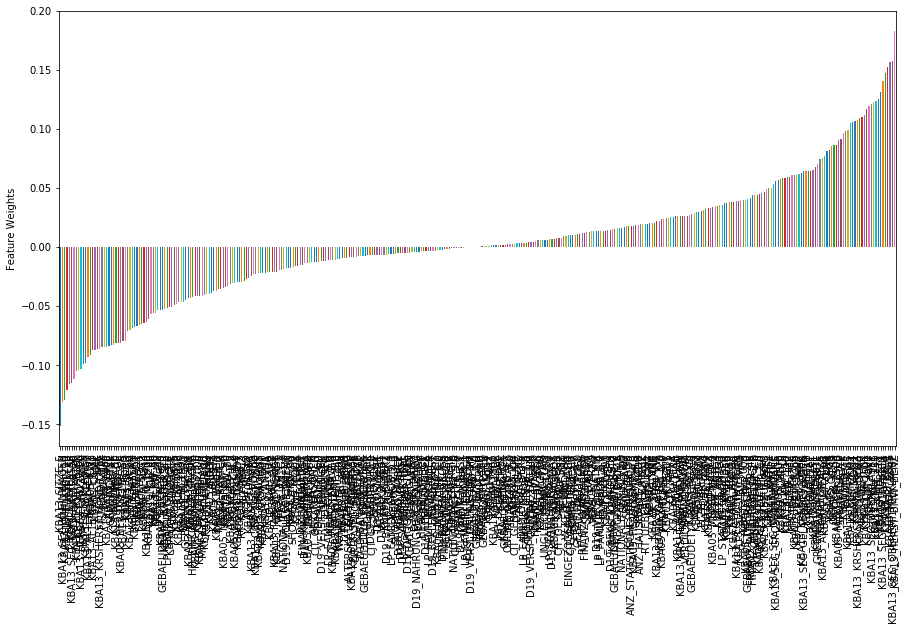

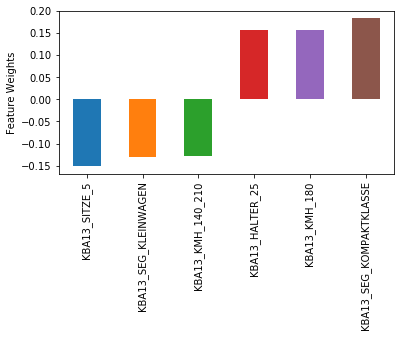

In [33]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca_results(azdias_final, azdias_pca_200, component_number = 2)

Explained Variance     LNR  AKT_DAT_KL  ANZ_HAUSHALTE_AKTIV  \
Dimension 1                0.0726 -0.0295      0.0616               0.0832   
Dimension 2                0.0511  0.0816      0.0129               0.0192   
Dimension 3                0.0417 -0.0259     -0.0460               0.0198   
Dimension 4                0.0284 -0.0725     -0.1094               0.0104   
Dimension 5                0.0233 -0.1126      0.0599               0.0094   
Dimension 6                0.0204 -0.0126     -0.0059              -0.0025   
Dimension 7                0.0193 -0.0207     -0.0138               0.0277   
Dimension 8                0.0169 -0.0329     -0.0196               0.0063   
Dimension 9                0.0155 -0.0736      0.0275              -0.0607   
Dimension 10               0.0147  0.0468     -0.0053               0.0285   
Dimension 11               0.0133 -0.0089     -0.0104               0.0552   
Dimension 12               0.0119 -0.0389     -0.0018               0.0275   
Dimension 13               0.0106 -0.0781      0.0004               0.0988   
Dimension 14               0.0097  0.0308     -0.0051               0.0746   
Dimension 15               0.0095  0.0168     -0.0047               0.1255   
Dimension 16               0.0090 -0.0607     -0.0022              -0.0212   
Dimension 17               0.0083  0.0314      0.0054               0.0258   
Dimension 18               0.0082 -0.0124     -0.0216               0.1202   
Dimension 19               0.0079 -0.0932      0.0232               0.1027   
Dimension 20               0.0077 -0.0274     -0.0472               0.0646   
Dimension 21               0.0075 -0.0019     -0.0140              -0.0569   
Dimension 22               0.0074  0.0100     -0.0040               0.0340   
Dimension 23               0.0072 -0.0057      0.0098               0.0984   
Dimension 24               0.0071 -0.0077      0.0659               0.1244   
Dimension 25               0.0067  0.0274      0.0470              -0.0034   
Dimension 26               0.0067  0.0047      0.0364              -0.0038   
Dimension 27               0.0064 -0.0102      0.0914              -0.0412   
Dimension 28               0.0062  0.0359     -0.0105               0.0682   
Dimension 29               0.0059  0.0424      0.0236               0.0765   
Dimension 30               0.0057 -0.0131     -0.0124               0.0922   
...                           ...     ...         ...                  ...   
Dimension 171              0.0017 -0.0966     -0.1755              -0.0128   
Dimension 172              0.0016  0.0848     -0.1277              -0.0496   
Dimension 173              0.0016 -0.0167     -0.1909              -0.0892   
Dimension 174              0.0016  0.0767      0.0756              -0.0202   
Dimension 175              0.0016 -0.1604     -0.0016               0.0292   
Dimension 176              0.0016  0.0320     -0.1117              -0.1399   
Dimension 177              0.0016  0.0094     -0.0283              -0.0575   
Dimension 178              0.0016  0.1325     -0.0129              -0.0828   
Dimension 179              0.0015 -0.0413     -0.0440              -0.0286   
Dimension 180              0.0015  0.1488      0.0180               0.0236   
Dimension 181              0.0015 -0.1611      0.0216              -0.0511   
Dimension 182              0.0015 -0.1029      0.0307              -0.0262   
Dimension 183              0.0015  0.1264      0.2090              -0.0572   
Dimension 184              0.0015 -0.0250      0.1214              -0.0694   
Dimension 185              0.0015  0.0075     -0.1338              -0.0524   
Dimension 186              0.0014  0.1282      0.3463              -0.0065   
Dimension 187              0.0014 -0.1974      0.1760               0.0137   
Dimension 188              0.0014  0.0398      0.0322              -0.0233   
Dimension 189              0.0014  0.1679     -0.1081              -0.0092   
Dimension 190              0.0014 -0.

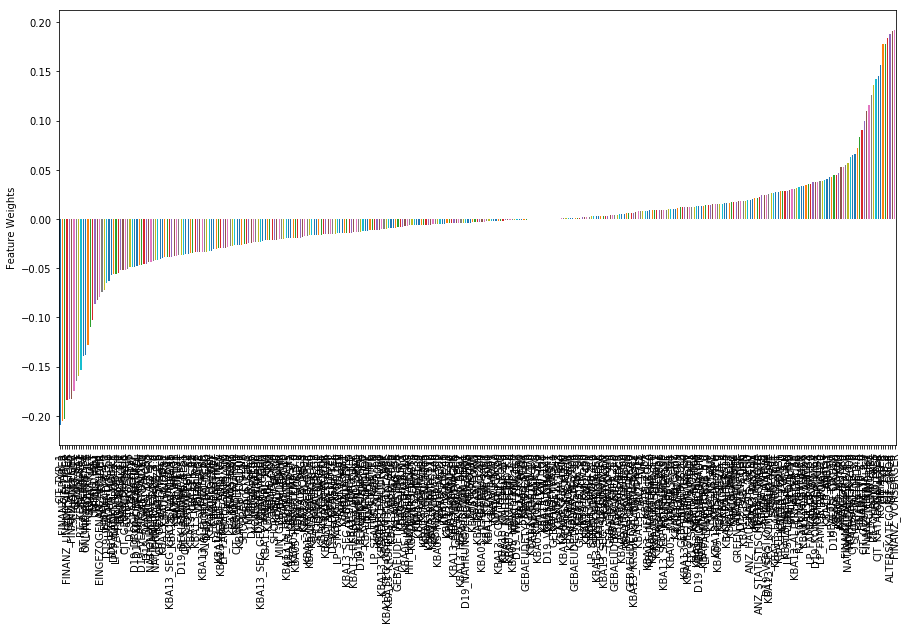

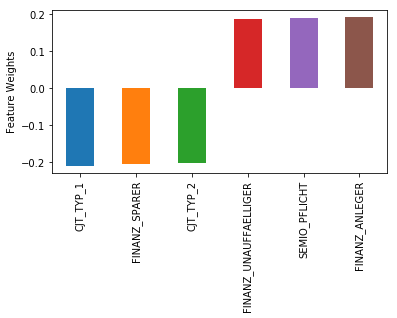

In [34]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca_results(azdias_final, azdias_pca_200, component_number = 3)

Explained Variance     LNR  AKT_DAT_KL  ANZ_HAUSHALTE_AKTIV  \
Dimension 1                0.0726 -0.0295      0.0616               0.0832   
Dimension 2                0.0511  0.0816      0.0129               0.0192   
Dimension 3                0.0417 -0.0259     -0.0460               0.0198   
Dimension 4                0.0284 -0.0725     -0.1094               0.0104   
Dimension 5                0.0233 -0.1126      0.0599               0.0094   
Dimension 6                0.0204 -0.0126     -0.0059              -0.0025   
Dimension 7                0.0193 -0.0207     -0.0138               0.0277   
Dimension 8                0.0169 -0.0329     -0.0196               0.0063   
Dimension 9                0.0155 -0.0736      0.0275              -0.0607   
Dimension 10               0.0147  0.0468     -0.0053               0.0285   
Dimension 11               0.0133 -0.0089     -0.0104               0.0552   
Dimension 12               0.0119 -0.0389     -0.0018               0.0275   
Dimension 13               0.0106 -0.0781      0.0004               0.0988   
Dimension 14               0.0097  0.0308     -0.0051               0.0746   
Dimension 15               0.0095  0.0168     -0.0047               0.1255   
Dimension 16               0.0090 -0.0607     -0.0022              -0.0212   
Dimension 17               0.0083  0.0314      0.0054               0.0258   
Dimension 18               0.0082 -0.0124     -0.0216               0.1202   
Dimension 19               0.0079 -0.0932      0.0232               0.1027   
Dimension 20               0.0077 -0.0274     -0.0472               0.0646   
Dimension 21               0.0075 -0.0019     -0.0140              -0.0569   
Dimension 22               0.0074  0.0100     -0.0040               0.0340   
Dimension 23               0.0072 -0.0057      0.0098               0.0984   
Dimension 24               0.0071 -0.0077      0.0659               0.1244   
Dimension 25               0.0067  0.0274      0.0470              -0.0034   
Dimension 26               0.0067  0.0047      0.0364              -0.0038   
Dimension 27               0.0064 -0.0102      0.0914              -0.0412   
Dimension 28               0.0062  0.0359     -0.0105               0.0682   
Dimension 29               0.0059  0.0424      0.0236               0.0765   
Dimension 30               0.0057 -0.0131     -0.0124               0.0922   
...                           ...     ...         ...                  ...   
Dimension 171              0.0017 -0.0966     -0.1755              -0.0128   
Dimension 172              0.0016  0.0848     -0.1277              -0.0496   
Dimension 173              0.0016 -0.0167     -0.1909              -0.0892   
Dimension 174              0.0016  0.0767      0.0756              -0.0202   
Dimension 175              0.0016 -0.1604     -0.0016               0.0292   
Dimension 176              0.0016  0.0320     -0.1117              -0.1399   
Dimension 177              0.0016  0.0094     -0.0283              -0.0575   
Dimension 178              0.0016  0.1325     -0.0129              -0.0828   
Dimension 179              0.0015 -0.0413     -0.0440              -0.0286   
Dimension 180              0.0015  0.1488      0.0180               0.0236   
Dimension 181              0.0015 -0.1611      0.0216              -0.0511   
Dimension 182              0.0015 -0.1029      0.0307              -0.0262   
Dimension 183              0.0015  0.1264      0.2090              -0.0572   
Dimension 184              0.0015 -0.0250      0.1214              -0.0694   
Dimension 185              0.0015  0.0075     -0.1338              -0.0524   
Dimension 186              0.0014  0.1282      0.3463              -0.0065   
Dimension 187              0.0014 -0.1974      0.1760               0.0137   
Dimension 188              0.0014  0.0398      0.0322              -0.0233   
Dimension 189              0.0014  0.1679     -0.1081              -0.0092   
Dimension 190              0.0014 -0.

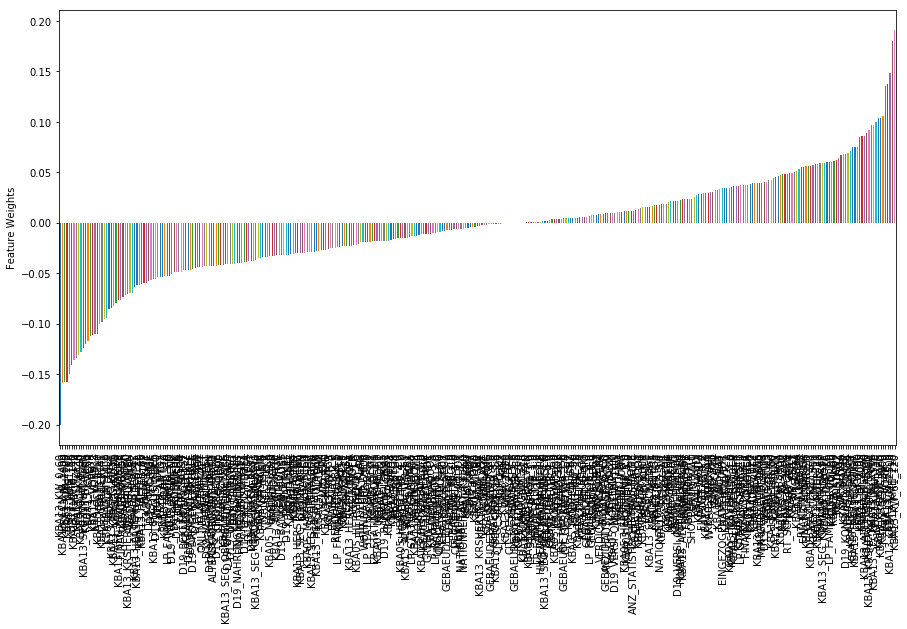

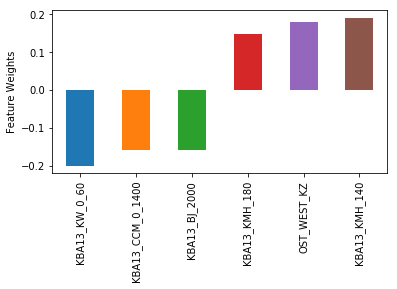

In [35]:
# Map weights for the fifth principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca_results(azdias_final, azdias_pca_200, component_number = 5)

### Interpret Principal Components

Below is a summary of the 1st, 2nd, 3rd, and 5th components from the PCA (the ones that end p being important for the most over- and under-represented clusters in the customers dataset.  Listed for component is the top 3 negatively and positively correlated feature weights and their meanings according to the order of the rankings within each column.  For some reason some of the columns do not have a description on the excel sheets that were provided. 

Component 1 is mainly related movement and cars, specifically high movement and more cars.

Component 2 is completly focused on cars, and in my opinion, in hard to interpret.  Perhaps more young people with more cars that are larger (and not smaller) and very specifically not 5 seaters.  Hmm.

Component 3 is is more finance related, specifically describing someone who is more traditional minded who spends money investing.

Component 5 is again all about cars - long, powerful cars with a high chance of them wielding a former GDR flag.

**Component #1** 

|Weight Description|Column Title                                        |Meaning                        |
|------------------|----------------------------------------------------|-------------------------------|
|#1 negative |PLZ8_ANTG1 - Number of 1-2 family houses in the PLZ8 region       |lower share of 1-2 family homes|
|#2 negative |MOBI_REGIO - Movement patterns                                    |very high movement             |
|#3 negative |KBA13_ANTG1 - No column description                               |                               |
|#3 positive |KBA13_AUTOQUOTE - share of cars per household within the PLZ8     |more cars per household        |
|#2 positive |MOBI_RASTER - No column description                               |                               |
|#1 positive |KBA05_AUTOQUOT - Share of cars per household                      |more cars per household        |

**Component #2**

|Weight Description|Column Title                                      |Meaning                          |
|------------------|--------------------------------------------------|---------------------------------|
|#1 negative |KBA13_SITZE_5 - number of cars with 5 seats in the PLZ8 |low number of cars with 5 seats  |
|#2 negative |KBA13_SEG_KLEINWAGEN - share of small and very small cars in the PLZ8 |less small cars in area|
|#3 negative |KBA13_KMH_140_210 - share of cars with max speed between 140 and 210 km/h within the PLZ8 | less share of cars|
|#3 positive |KBA13_HALTER_25 - share of car owners between 21 and 25 within the PLZ8| 20-25 yr old with cars|
|#2 positive |KBA13_KMH_180 - share of cars with max speed between 110 km/h and 180km/h within the PLZ8 | more cars...?|
|#1 positive |KBA13_SEG_KOMPAKTKLASSE - share of low midclass cars in the PLZ8 |more midclass cars      |

**Component #3**

|Weight Description|Column Title                |Meaning                 |
|------------------|----------------------------|------------------------|
|#1 negative |CJT_TYP_1 - No column description |                        |
|#2 negative |FINANZ_SPARER - financial typology: money saver |money spender |
|#3 negative |CJT_TYP_2 - No column description |                        |
|#3 positive |FINANZ_UNAUFFAELLIGER - financial typology: unremarkable |unremarkable (money related) |
|#2 positive |SEMIO_PFLICHT - affinity indicating in what way the person is dutyfull traditional minded|traditional-minded|
|#1 positive |FINANZ_ANLEGER - financial typology: investor  |investor      |

**Component #5**

|Weight Description|Column Title                                 |Meaning                |
|------------------|---------------------------------------------|-----------------------|
|#1 negative |KBA13_KW_0_60 - share of cars with less than 61 KW engine power - PLZ8 |less cars with 61 KW engines |
|#2 negative |KBA13_CCM_0_1400 - share of cars with less than 1401ccm within the PLZ8|less cars less than 1401 cm |
|#3 negative |KBA13_BJ_2000 - share of cars built between 2000 and 2003 within the PLZ8| less 2000-2003 cars|
|#3 positive |KBA13_KMH_180 - share of cars with max speed between 110 km/h and 180km/h within the PLZ8|more cars|
|#2 positive |OST_WEST_KZ - flag indicating the former GDR/FRG        |GDR flag on building  |
|#1 positive |KBA13_KMH_140 - share of cars with max speed between 110 km/h and 140km/h within the PLZ8|more cars|

<a id='part1clustering'></a> 
### Perform K-Means Clustering

From term 1 project: You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [14]:
# Over a number of different cluster counts...
# run k-means clustering on the data and...
# compute the average within-cluster distances.

def elbow_plot(data, start_K, end_K, step):
    '''
    Generate an elbow plot to find optimal number of clusters
    graphing K values from start_K to end_K every step value
    
    INPUT: 
        data: Demographics DataFrame
        start_K: Inclusive starting value for cluster number
        end_K: Exclusive stopping value for cluster number
        step: Step value between start_K and end_K
    OUTPUT: Trimmed and cleaned demographics DataFrame
    '''
    score_list = []

    for i in range(start_K, end_K, step):
        print(i)
        start = time.time()
        kmeans = KMeans(i)
        model = kmeans.fit(data)
        score = model.score(data)
        score_list.append(abs(score))
        end = time.time()
        elapsed_time = end - start
        print(elapsed_time)

    plt.plot(range(start_K, end_K, step), 
    score_list, linestyle='--', marker='o', color='b');
    plt.xlabel('# of clusters K');
    plt.ylabel('Sum of squared errors');
    plt.title('SSE vs. K');
    plt.savefig('elbow_plot.png')

1
37.912030935287476
3
273.84494948387146
5
778.5425744056702
7
875.2392861843109
9
1521.1932709217072
11
1588.4942820072174
13
1647.3004620075226
15
1731.3703107833862
17
2102.043183326721
19
2044.1062817573547


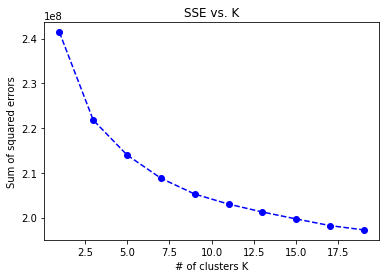

In [17]:
# Investigate the change in within-cluster distance across number of clusters.

elbow_plot(azdias_X_pca_200, 1, 20, 2)

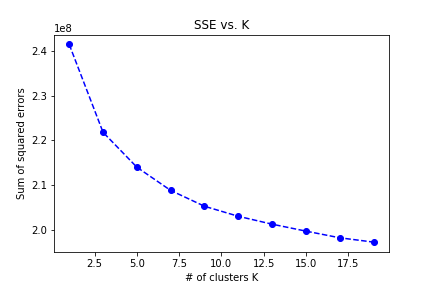

In [27]:
# Have saved version of embow plot since it takes hours to generate
from IPython.display import Image
Image(filename='elbow_plot.png') 

In [18]:
# Fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data (azdias).

azdias_kmeans = KMeans(7)
azdias_model = azdias_kmeans.fit(azdias_X_pca_200)
azdias_labels = azdias_model.predict(azdias_X_pca_200)

In [19]:
# View first few labels predicted for the azdias dataset
azdias_labels[0:15]

array([0, 0, 4, 6, 4, 0, 0, 5, 5, 2, 0, 0, 5, 1, 0])

In [20]:
# Perform PCA on the customers dataset using the pca generated using azdias
customers_pca_200 = azdias_pca_200.transform(customers_final)

In [21]:
# Perform clustering on customers dataset using model generated using azdias
customers_labels = azdias_model.predict(customers_pca_200)

In [22]:
# View first few labels predicted for the customers dataset
customers_labels[0:15]

array([4, 2, 4, 6, 5, 4, 5, 5, 5, 4, 6, 2, 6, 6, 6])

<a id='part1compare'></a>
### Compare Customer Data to Demographics Data

At this point, I have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. Now I will compare the two cluster distributions to see where the strongest customer base for the company is.

In [23]:
# Calculate the proportions of each cluster for the general population.
# Include the data that was initially removed due to too many NaNas when
# calculating the proportions and include this data as cluster -1.

general_pop = 891221

azdias_counter = Counter(azdias_labels)
azdias_proportions = [(i, azdias_counter[i] / general_pop * 100.0) for i in azdias_counter]
azdias_proportions.sort(key=itemgetter(0))
azdias_proportions = np.array(azdias_proportions)

dropped_gen_pop = 100 - azdias_proportions[:, 1].sum()

azdias_proportions = np.insert(azdias_proportions, 0, values=[-1, dropped_gen_pop], axis=0)
azdias_proportions

array([[-1.        , 17.81062161],
       [ 0.        , 14.64631107],
       [ 1.        , 11.63033636],
       [ 2.        , 11.65648027],
       [ 3.        ,  9.95622859],
       [ 4.        , 13.85795442],
       [ 5.        ,  9.14621626],
       [ 6.        , 11.29585142]])

In [24]:
# Calculate the proportions of each cluster for the customer population.
# Include the data that was initially removed due to too many NaNas when
# calculating the proportions and include this data as cluster -1.
cust_pop = 191652

customers_counter = Counter(customers_labels)
customers_proportions = [(i, customers_counter[i] / cust_pop * 100.0) for i in customers_counter]
customers_proportions.sort(key=itemgetter(0))
customers_proportions = np.array(customers_proportions)

dropped_cust_pop = 100 - customers_proportions[:, 1].sum()

customers_proportions = np.insert(customers_proportions, 0, values=[-1, dropped_cust_pop], axis=0)
customers_proportions

array([[-1.        , 31.54050049],
       [ 0.        ,  0.87554526],
       [ 1.        ,  1.59038257],
       [ 2.        ,  9.06382401],
       [ 3.        ,  2.53741156],
       [ 4.        , 23.21812452],
       [ 5.        , 16.54717926],
       [ 6.        , 14.62703233]])

In [25]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
representation_ratio = customers_proportions[:, 1]/azdias_proportions[:, 1]

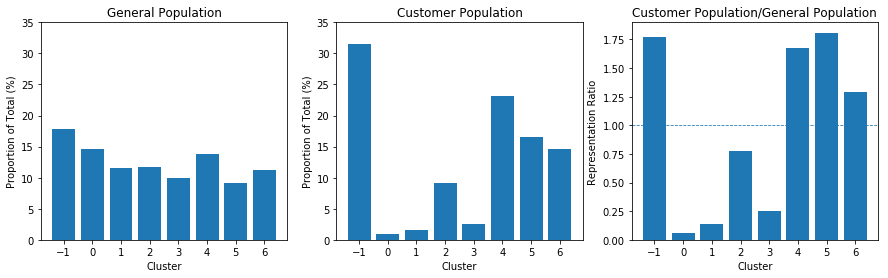

In [26]:
# Plot the proportions for the general population, the customer population,
# and the ratio of customer/general populations.
plt.figure(figsize=(15, 4))

ax1 = plt.subplot(131)
ax1.bar(azdias_proportions[:, 0], azdias_proportions[:, 1])
ax1.set_xticks(azdias_proportions[:, 0])
ax1.set_ylim(ymax = 35)
ax1.set_xlabel("Cluster")
ax1.set_ylabel("Proportion of Total (%)")
plt.title('General Population')

ax2 = plt.subplot(132)
ax2.bar(customers_proportions[:, 0], customers_proportions[:, 1])
ax2.set_xticks(azdias_proportions[:, 0])
ax2.set_ylim(ymax = 35)
ax2.set_xlabel("Cluster")
ax2.set_ylabel("Proportion of Total (%)")
plt.title('Customer Population')

ax3 = plt.subplot(133)
ax3.bar(azdias_proportions[:, 0], representation_ratio)
ax3.set_xticks(azdias_proportions[:, 0])
ax3.set_xlabel("Cluster")
ax3.set_ylabel("Representation Ratio")
ax3.axhline(y=1, linestyle = "--", linewidth = 0.8)
plt.title('Customer Population/General Population')

plt.savefig('population_proportions.png');

In [28]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

weights_5 = azdias_model.cluster_centers_[5]
components_5 = list(range(1, 201))
cluster_components_5 = pd.DataFrame({'Weights': weights_5, 'Component': components_5})
cluster_components_5.sort_values('Weights',ascending=False)

Weights  Component
1    6.837483          2
2    1.665249          3
4    1.083776          5
3    1.022458          4
8    0.959715          9
11   0.825929         12
10   0.346800         11
15   0.256655         16
38   0.188197         39
34   0.175617         35
19   0.148039         20
62   0.140143         63
39   0.131537         40
5    0.112559          6
49   0.094627         50
26   0.094411         27
42   0.088428         43
46   0.084481         47
18   0.077210         19
142  0.076854        143
85   0.075736         86
166  0.074026        167
121  0.068916        122
53   0.064798         54
35   0.064693         36
51   0.056026         52
124  0.055628        125
64   0.053640         65
115  0.052393        116
77   0.052262         78
..        ...        ...
13  -0.048742         14
167 -0.051970        168
96  -0.052025         97
125 -0.054550        126
158 -0.055456        159
188 -0.056210        189
68  -0.059810         69
164 -0.064260        165
74  -0.064846         75
33  -0.066547         34
41  -0.068834         42
127 -0.074642        128
143 -0.075204        144
50  -0.075458         51
40  -0.076304         41
31  -0.083106         32
36  -0.087168         37
56  -0.088102         57
112 -0.092905        113
45  -0.109310         46
12  -0.129320         13
29  -0.143939         30
28  -0.150495         29
32  -0.173733         33
21  -0.214602         22
14  -0.231325         15
9   -0.247481         10
7   -0.276403          8
6   -0.514128          7
0   -1.604443          1

[200 rows x 2 columns]

In [30]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

weights_0 = azdias_model.cluster_centers_[0]
components_0 = list(range(1, 201))
cluster_components_0 = pd.DataFrame({'Weights': weights_0, 'Component': components_0})
cluster_components_0.sort_values('Weights',ascending=False)

Weights  Component
4    0.612370          5
10   0.343343         11
1    0.308101          2
14   0.244757         15
16   0.219022         17
0    0.175803          1
34   0.134253         35
40   0.127488         41
42   0.114266         43
30   0.068367         31
58   0.068247         59
39   0.062700         40
62   0.058457         63
81   0.057374         82
26   0.057316         27
21   0.055769         22
47   0.054238         48
32   0.052979         33
129  0.050954        130
143  0.047057        144
78   0.046601         79
36   0.044760         37
158  0.043424        159
172  0.040568        173
150  0.038960        151
13   0.037493         14
90   0.037428         91
33   0.036753         34
109  0.033313        110
132  0.032328        133
..        ...        ...
41  -0.033050         42
20  -0.035704         21
19  -0.041766         20
27  -0.044707         28
99  -0.044868        100
54  -0.045638         55
85  -0.046127         86
9   -0.052866         10
142 -0.052878        143
44  -0.053044         45
35  -0.056253         36
63  -0.057801         64
12  -0.061097         13
74  -0.062492         75
60  -0.063922         61
22  -0.071514         23
45  -0.083840         46
28  -0.092369         29
67  -0.093698         68
25  -0.123889         26
23  -0.150840         24
15  -0.187460         16
17  -0.214102         18
8   -0.260860          9
11  -0.340784         12
5   -0.348691          6
7   -0.547623          8
6   -0.853803          7
3   -2.281661          4
2   -3.836246          3

[200 rows x 2 columns]

For cluster 5, the most overrepresented cluster in the customer data (and thus the company's target market), the components with the highest positive and negative weight are 2 and 1 respectively. I find cluster 2 hard to interpret, if we consider a negative correlation with component 1 then perhaps the customers are people without cars with low movement.  

For cluster 0, the most underrepresented cluster in the customer data (and thus outside of the company's target market), the components with the highest positive and negative weight are 5 and 3 respectively. These people are people with long, powerful cars who are ... money savers.

I find this analysis generally meaningless and uninterpretable.  A more in depth analysis of the clusters would include looking at more than the highest positive and negatively weighted components but this was done for simplicity.  I would be interested in running the analysis again without all the car related columns, or somehow whittling it down to something more understandable.

<a id='part2'></a>
## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

<a id='part1base'></a> 
## Base Machine Learning Models

In [5]:
# Load the training mailout dataset
train = pd.read_csv('train.csv')
del train['Unnamed: 0']
train.head()

C:\Users\ursula\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


LNR  AGER_TYP  AKT_DAT_KL  ALTER_HH  ALTER_KIND1  ALTER_KIND2  \
0  1763         2         1.0       8.0          NaN          NaN   
1  1771         1         4.0      13.0          NaN          NaN   
2  1776         1         1.0       9.0          NaN          NaN   
3  1460         2         1.0       6.0          NaN          NaN   
4  1783         2         1.0       9.0          NaN          NaN   

   ALTER_KIND3  ALTER_KIND4  ALTERSKATEGORIE_FEIN  ANZ_HAUSHALTE_AKTIV  \
0          NaN          NaN                   8.0                 15.0   
1          NaN          NaN                  13.0                  1.0   
2          NaN          NaN                   7.0                  0.0   
3          NaN          NaN                   6.0                  4.0   
4          NaN          NaN                   9.0                 53.0   

          ...           VK_DHT4A  VK_DISTANZ  VK_ZG11  W_KEIT_KIND_HH  \
0         ...                5.0         2.0      1.0             6.0   
1         ...                1.0         2.0      1.0             4.0   
2         ...                6.0         4.0      2.0             NaN   
3         ...                8.0        11.0     11.0             6.0   
4         ...                2.0         2.0      1.0             6.0   

   WOHNDAUER_2008  WOHNLAGE  ZABEOTYP RESPONSE ANREDE_KZ ALTERSKATEGORIE_GROB  
0             9.0       3.0         3        0         2                    4  
1             9.0       7.0         1        0         2                    3  
2             9.0       2.0         3        0         1                    4  
3             9.0       1.0         3        0         2                    4  
4             9.0       3.0         3        0         1                    3  

[5 rows x 367 columns]

In [6]:
# Clean the training data (may need to rerun cell with cleaning function, loading unknowns.pickle)
train = clean_data(train, unknowns)
train.head()

LNR  AKT_DAT_KL  ANZ_HAUSHALTE_AKTIV  ANZ_HH_TITEL  ANZ_KINDER  \
0  1763.0         1.0                 15.0           0.0         0.0   
1  1771.0         4.0                  1.0           0.0         0.0   
2  1776.0         1.0                  0.0           NaN         0.0   
3  1460.0         1.0                  4.0           0.0         0.0   
4  1783.0         1.0                 53.0           0.0         0.0   

   ANZ_PERSONEN  ANZ_STATISTISCHE_HAUSHALTE  ANZ_TITEL  ARBEIT  BALLRAUM  \
0           1.0                        13.0        0.0     3.0       5.0   
1           2.0                         1.0        0.0     2.0       5.0   
2           0.0                         1.0        0.0     4.0       1.0   
3           2.0                         4.0        0.0     4.0       2.0   
4           1.0                        44.0        0.0     3.0       4.0   

       ...      LP_STATUS_GROB_5.0 NATIONALITAET_KZ_1.0  NATIONALITAET_KZ_2.0  \
0      ...                       0                    1                     0   
1      ...                       0                    0                     1   
2      ...                       1                    1                     0   
3      ...                       0                    1                     0   
4      ...                       0                    1                     0   

   NATIONALITAET_KZ_3.0  SHOPPER_TYP_0.0  SHOPPER_TYP_1.0  SHOPPER_TYP_2.0  \
0                     0                0                0                0   
1                     0                0                0                1   
2                     0                0                0                0   
3                     0                0                1                0   
4                     0                0                1                0   

   SHOPPER_TYP_3.0  VERS_TYP_1.0  VERS_TYP_2.0  
0                1             0             1  
1                0             1             0  
2                1             1             0  
3                0             0             1  
4                0             1             0  

[5 rows x 362 columns]

In [7]:
# Define the labels (y) to be the response column, and the rest of the columns to be X
y = train['RESPONSE']
del train['RESPONSE']
X = train
y.shape, X.shape

((33266,), (33266, 361))

In [8]:
# Obtain the vale counts for the response column
y.value_counts()

0.0    32854
1.0      412
Name: RESPONSE, dtype: int64

In [9]:
y.head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: RESPONSE, dtype: float64

**Discussion** <br>
The response column is quite imbalanced with 42430/(42430 + 532) = 98.8% no response and 532/(42430 + 532) = 1.2% response.  From searchimg online it seems like using a ROC AUC analysis will be better than accuracy for getting a score for our models.

http://www.davidsbatista.net/blog/2018/08/19/NLP_Metrics/

In [10]:
# The imputer does not work at this stage because the columns CAMEO_DEUG_2015 and CAMEO_INTL_2015 
# have values that strings "X" and "XX".  EINGEFUEGT_AM has a similar issue. Remove these columns 
# for simplicity.  
del X['CAMEO_DEUG_2015']
del X['CAMEO_INTL_2015']
del X['EINGEFUEGT_AM']

# Perform imputation on train df
imputer = Imputer()
X = pd.DataFrame(imputer.fit_transform(X), columns = X.columns)
X.head()

C:\Users\ursula\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


LNR  AKT_DAT_KL  ANZ_HAUSHALTE_AKTIV  ANZ_HH_TITEL  ANZ_KINDER  \
0  1763.0         1.0                 15.0      0.000000         0.0   
1  1771.0         4.0                  1.0      0.000000         0.0   
2  1776.0         1.0                  0.0      0.047864         0.0   
3  1460.0         1.0                  4.0      0.000000         0.0   
4  1783.0         1.0                 53.0      0.000000         0.0   

   ANZ_PERSONEN  ANZ_STATISTISCHE_HAUSHALTE  ANZ_TITEL  ARBEIT  BALLRAUM  \
0           1.0                        13.0        0.0     3.0       5.0   
1           2.0                         1.0        0.0     2.0       5.0   
2           0.0                         1.0        0.0     4.0       1.0   
3           2.0                         4.0        0.0     4.0       2.0   
4           1.0                        44.0        0.0     3.0       4.0   

       ...       LP_STATUS_GROB_5.0  NATIONALITAET_KZ_1.0  \
0      ...                      0.0                   1.0   
1      ...                      0.0                   0.0   
2      ...                      1.0                   1.0   
3      ...                      0.0                   1.0   
4      ...                      0.0                   1.0   

   NATIONALITAET_KZ_2.0  NATIONALITAET_KZ_3.0  SHOPPER_TYP_0.0  \
0                   0.0                   0.0              0.0   
1                   1.0                   0.0              0.0   
2                   0.0                   0.0              0.0   
3                   0.0                   0.0              0.0   
4                   0.0                   0.0              0.0   

   SHOPPER_TYP_1.0  SHOPPER_TYP_2.0  SHOPPER_TYP_3.0  VERS_TYP_1.0  \
0              0.0              0.0              1.0           0.0   
1              0.0              1.0              0.0           1.0   
2              0.0              0.0              1.0           1.0   
3              1.0              0.0              0.0           0.0   
4              1.0              0.0              0.0           1.0   

   VERS_TYP_2.0  
0           1.0  
1           0.0  
2           0.0  
3           1.0  
4           0.0  

[5 rows x 358 columns]

In [11]:
# Apply feature scaling to the train df
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns = X.columns)
X.head()

LNR  AKT_DAT_KL  ANZ_HAUSHALTE_AKTIV  ANZ_HH_TITEL  ANZ_KINDER  \
0 -1.650851   -0.283484             0.569340 -1.299679e-01   -0.221665   
1 -1.650530    1.550148            -0.371327 -1.299679e-01   -0.221665   
2 -1.650330   -0.283484            -0.438518 -1.884150e-17   -0.221665   
3 -1.663005   -0.283484            -0.169756 -1.299679e-01   -0.221665   
4 -1.650049   -0.283484             3.122579 -1.299679e-01   -0.221665   

   ANZ_PERSONEN  ANZ_STATISTISCHE_HAUSHALTE  ANZ_TITEL    ARBEIT  BALLRAUM  \
0     -0.756359                    0.498146  -0.091462 -0.037869  0.334508   
1     -0.023869                   -0.364020  -0.091462 -1.006666  0.334508   
2     -1.488850                   -0.364020  -0.091462  0.930927 -1.490367   
3     -0.023869                   -0.148478  -0.091462  0.930927 -1.034148   
4     -0.756359                    2.725409  -0.091462 -0.037869 -0.121711   

       ...       LP_STATUS_GROB_5.0  NATIONALITAET_KZ_1.0  \
0      ...                -0.586769              0.212402   
1      ...                -0.586769             -4.708050   
2      ...                 1.704248              0.212402   
3      ...                -0.586769              0.212402   
4      ...                -0.586769              0.212402   

   NATIONALITAET_KZ_2.0  NATIONALITAET_KZ_3.0  SHOPPER_TYP_0.0  \
0             -0.142603             -0.119065        -0.463606   
1              7.012486             -0.119065        -0.463606   
2             -0.142603             -0.119065        -0.463606   
3             -0.142603             -0.119065        -0.463606   
4             -0.142603             -0.119065        -0.463606   

   SHOPPER_TYP_1.0  SHOPPER_TYP_2.0  SHOPPER_TYP_3.0  VERS_TYP_1.0  \
0        -0.586075        -0.465136         1.282488     -1.007786   
1        -0.586075         2.149908        -0.779734      0.992274   
2        -0.586075        -0.465136         1.282488      0.992274   
3         1.706267        -0.465136        -0.779734     -1.007786   
4         1.706267        -0.465136        -0.779734      0.992274   

   VERS_TYP_2.0  
0      1.031147  
1     -0.969794  
2     -0.969794  
3      1.031147  
4     -0.969794  

[5 rows x 358 columns]

In [12]:
def classifier_roc(clf, param_grid, X=X, y=y):
    """
    Fits a classifier to its training data and prints its ROC AUC score.
    
    INPUT:
    - clf (classifier): classifier to fit
    - param_grid (dict): classifier parameters used with GridSearchCV
    - X (DataFrame): training input features
    - y (DataFrame): training output 
            
    OUTPUT:
    - classifier: input classifier fitted to the training data
    """
    
    # cv uses StratifiedKFold
    # scoring roc_auc available as parameter
    grid = GridSearchCV(estimator=clf, param_grid=param_grid, scoring='roc_auc', cv=5)
    grid.fit(X, y)
    print(grid.best_score_)
    
    return grid.best_estimator_

In [17]:
# LogisticRegression

start = time.time()

logreg = LogisticRegression()
print(classifier_roc(logreg, {}))

end = time.time()
logreg_time = end - start
logreg_time

C:\Users\ursula\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\ursula\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\ursula\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\ursula\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\ursula\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to sile

0.649620614834891
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)


62.31971263885498

In [18]:
# RandomForestClassifier

start = time.time()

rfc = RandomForestClassifier()
print(classifier_roc(rfc, {}))

end = time.time()
rfc_time = end - start
rfc_time

C:\Users\ursula\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\ursula\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\ursula\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\ursula\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\ursula\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:2

0.523057343640648
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


7.759346008300781

In [19]:
# AdaBoostClassifier

start = time.time()

ada = AdaBoostClassifier()
print(classifier_roc(ada, {}))

end = time.time()
ada_time = end - start
ada_time

0.6851325570586659
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)


78.36282157897949

In [20]:
# GradientBoostingClassifier

start = time.time()

gbc = GradientBoostingClassifier()
print(classifier_roc(gbc, {}))

end = time.time()
gbc_time = end - start
gbc_time

0.6976921955781937
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)


266.19257712364197

In [21]:
# SupportVectorMachine

start = time.time()

svc = SVC()
print(classifier_roc(svc, {}))

end = time.time()
svc_time = end - start
svc_time

C:\Users\ursula\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\ursula\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\ursula\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\ursula\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureW

0.6061230410803673
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)


2655.6983926296234

**Classifier Results**

|Classifier                 |F1 Score  |Time to Run (s)|
|---------------------------|----------|---------------|
|LogisticRegression         |0.65      |62             |
|RandomForestClassifier     |0.52      |8              |
|AdaBoostClassifier         |0.69      |78             |
|GradientBoostingClassifier |0.70      |266            |
|SupportVectorMachine       |0.61      |2656           |

The GradientBoostingClassifier had the highest ROC AUC of 0.70, followed closely by the AdaBoostClassifier with an ROC AUC score of 0.69.  While the GradientBoostingClassifier was slightly better, the AdaBoostClassifier was 3.4 times faster.  I will choose the AdaBoostClassifier as the model to optimize - this will be more practical although if you were really trying to win a Kaggle competition you may weigh fractions of a scores improvement of practicality.  

<a id='part1optimize'></a> 
## Optimize A Single Model

In [26]:
start = time.time()

param_grid = {'algorithm': ['SAMME.R'],
             'learning_rate': [0.01, 0.1, 1.0],
             'n_estimators': [20, 50, 100]}

grid = GridSearchCV(estimator=AdaBoostClassifier(), param_grid=param_grid, scoring='roc_auc', cv=5)
grid.fit(X, y)
print(grid.best_score_)
print(grid.best_estimator_)

end = time.time()
cv_time = end - start
cv_time

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] algorithm=SAMME.R, learning_rate=0.01, n_estimators=20 ..........


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  algorithm=SAMME.R, learning_rate=0.01, n_estimators=20, total=   5.0s
[CV] algorithm=SAMME.R, learning_rate=0.01, n_estimators=20 ..........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.3s remaining:    0.0s


[CV]  algorithm=SAMME.R, learning_rate=0.01, n_estimators=20, total=   4.8s
[CV] algorithm=SAMME.R, learning_rate=0.01, n_estimators=20 ..........
[CV]  algorithm=SAMME.R, learning_rate=0.01, n_estimators=20, total=   4.7s
[CV] algorithm=SAMME.R, learning_rate=0.01, n_estimators=20 ..........
[CV]  algorithm=SAMME.R, learning_rate=0.01, n_estimators=20, total=   4.7s
[CV] algorithm=SAMME.R, learning_rate=0.01, n_estimators=20 ..........
[CV]  algorithm=SAMME.R, learning_rate=0.01, n_estimators=20, total=   4.7s
[CV] algorithm=SAMME.R, learning_rate=0.01, n_estimators=50 ..........
[CV]  algorithm=SAMME.R, learning_rate=0.01, n_estimators=50, total=  11.5s
[CV] algorithm=SAMME.R, learning_rate=0.01, n_estimators=50 ..........
[CV]  algorithm=SAMME.R, learning_rate=0.01, n_estimators=50, total=  12.3s
[CV] algorithm=SAMME.R, learning_rate=0.01, n_estimators=50 ..........
[CV]  algorithm=SAMME.R, learning_rate=0.01, n_estimators=50, total=  12.0s
[CV] algorithm=SAMME.R, learning_rate=0.01

[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed: 11.3min finished


0.7091991878278016
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.1, n_estimators=50, random_state=None)


695.2347180843353

**Discussion** <br>
Performing the optimization of the model only increased the ROC AUC from 0.69 to 0.71.

<a id='part3'></a>
## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [135]:
# mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

In [136]:
# mailout_test.to_csv('test.csv')

<a id='conclusions'></a>
## Conclusions

<a id='resources'></a>
## Resources